In [12]:
# !pip install --upgrade pip
# !pip install python-docx
# !pip install antropy


from joblib import Parallel, delayed

import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dataclasses
import math as math
from sklearn.svm import OneClassSVM
from sklearn.model_selection import cross_validate, RandomizedSearchCV
import statsmodels.stats.api as sms
from tqdm.auto import tqdm
from dataclasses import asdict
from sklearn import svm
from tqdm import tqdm
import warnings
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, accuracy_score, make_scorer, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold # Feature selector
from sklearn.model_selection import KFold
from sklearn import metrics
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense,
    Input,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Lambda,
    Conv2D,
    MaxPooling2D,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling1D,
    Activation
)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Ftrl, Nadam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import concatenate as keras_concat
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import EarlyStopping




import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import iqr
from scipy.stats import median_absolute_deviation
from scipy.stats import mode
from scipy.signal import find_peaks
from scipy.signal import peak_widths
# from scipy.special import entr
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler, RobustScaler, PowerTransformer
get_new_scaler_dict = {"StandardScaler": StandardScaler, "MinMaxScaler": MinMaxScaler, "Normalizer": Normalizer, 
                       "MaxAbsScaler": MaxAbsScaler, "RobustScaler": RobustScaler, "PowerTransformer": PowerTransformer}
from sklearn.preprocessing import normalize
from sklearn.metrics import auc
# import antropy as ant
import time
# import docx

# Global utitlity functions are in separate notebook
# Global utitlity functions are in separate notebook
%run ./Classification_utility-functions.ipynb
%run ./SEED-CONSTANTS.ipynb


np.random.seed(SEED)
tf.random.set_seed(SEED)
print(f"Seed was set to: {SEED}")


print("Setup Complete")

SEED: 567
FINAL_EXP_RESULTS_PATH: clip=False_experiments_results
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case
EER: 0.167, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.333, Threshold: 1.000 <-- Worse case
--------------------Utility functions imported--------------------
SEED: 567
FINAL_EXP_RESULTS_PATH: clip=False_experiments_results
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Preprocessing utility functions imported--------------------
SEED: 567
FINAL_EXP_RESULTS_PATH: clip=False_experiments_results
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Neu

In [2]:
@dataclasses.dataclass
class ExperimentParameters:
    """Contains all relevant parameters to run an experiment."""

    name: str  # Name of Experiments Parameter set. Used as identifier for charts etc.

    # Data / Splitting:
    frequency: int
    feature_cols: list  # Columns used as features
    max_subjects: int
    user_ids: list
    num_sample_points_per_exp: int
    exp_begin_cutoff_idx: int
    exp_end_cutoff_idx: int
        
#     exclude_subjects: list  # Don't load data from those users
    n_valid_train_subjects: int
    n_valid_test_subjects: int
    n_test_train_subjects: int
    n_test_test_subjects: int
    seconds_per_subject_train: float
    seconds_per_subject_test: float
    task_types: list  # Limit scenarios to [1, 3, 5] for sitting or [2, 4, 6] for walking, or don't limit (None)

    # Reshaping
    window_size: int  # After resampling
    nn_step_width: int
    ocsvm_step_width: int

    # Normalization
    scaler: str  # {"std", "robust", "minmax"}
    scaler_scope: str  # {"subject", "session"}
    scaler_global: bool  # scale training and testing sets at once (True), or fit scaler on training only (False)

    # Siamese Network
    max_pairs_per_session: int  # Max. number of pairs per session
    margin: float  # Contrastive Loss Margin
    model_variant: str  # {"1d", "2d"} Type of architecture
    filters: list  # List of length 4, containing number of filters for conv layers
    epochs_best: int  # Train epochs to for final model
    epochs_max: int
    batch_size: int
    optimizer: str  # Optimizer to use for Siamese Network
    optimizer_lr: float  # Learning Rate
    optimizer_decay: float

    # OCSVM
    ocsvm_kernel: str # ocsvm kernel
    ocsvm_nu: float  # Best value found in random search, used for final model
    ocsvm_gamma: float  # Best value found in random search, used for final model

    # Calculated values
    def __post_init__(self):
        # HDF key of table:
        self.table_name = f"sensors_{self.frequency}hz"

        # Number of samples per _session_ used for training:
        self.samples_per_subject_train = math.ceil(
            (self.seconds_per_subject_train * 100)
            / (100 / self.frequency)
            / self.window_size
        )

        # Number of samples per _session_ used for testing:
        self.samples_per_subject_test = math.ceil(
            (self.seconds_per_subject_test * 100)
            / (100 / self.frequency)
            / self.window_size
        )


# INSTANCES
# ===========================================================

# NAIVE_MINMAX (2D Filters)
# -----------------------------------------------------------
NAIVE_MINMAX_2D = ExperimentParameters(
    name="NAIVE-MINMAX-2D",
#     # Data / Splitting
    frequency=100,
    feature_cols=[
        "acc_x",
        "acc_y",
        "acc_z",
        "gyr_x",
        "gyr_y",
        "gyr_z"
    ],
    max_subjects=29,
    user_ids = [1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49],
    num_sample_points_per_exp=21000,
    exp_begin_cutoff_idx=500,
    exp_end_cutoff_idx=-500,
    n_valid_train_subjects=40,
    n_valid_test_subjects=10,
    n_test_train_subjects=10,
    n_test_test_subjects=30,
    seconds_per_subject_train=67.5,
    seconds_per_subject_test=67.5,
    task_types=None,
    # Reshaping
    window_size=100 * 1,  #1 sec
    nn_step_width=125,
    ocsvm_step_width=125,
    # Normalization
    scaler="minmax",
    scaler_scope="subject",
    scaler_global=True,
    # Siamese Network
    model_variant="2d",
    filters=[32, 64, 128, 32],
#     filters=[32, 64, 128, 64],
    epochs_best=35,
    epochs_max=40,
    batch_size=200,
    optimizer="sgd",
    optimizer_lr=0.01,
    optimizer_decay=0,
    max_pairs_per_session=60,  # => 4min
    margin=0.2,
    # OCSVM
    ocsvm_kernel="rbf",
    ocsvm_nu=0.092,
    ocsvm_gamma=1.151,
)  # <END NAIVE_APPROACH>

# VALID_MINMAX (2D)
# -----------------------------------------------------------
VALID_MINMAX_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-MINMAX-2D",
    task_types=None,
    scaler_global=False,
    epochs_max=40,
    ocsvm_nu=0.110,
    ocsvm_gamma=59.636,
)

# NAIVE_ROBUST (2D)
# -----------------------------------------------------------
NAIVE_ROBUST_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="NAIVE-ROBUST-2D",
    scaler="robust",
    optimizer="sgd",
    optimizer_lr=0.05, # Decreased, to avoid "all zeros" prediction
    optimizer_decay=0.002,
    epochs_best=5,
    ocsvm_nu=0.214,
    ocsvm_gamma=2.354,
)

# VALID_ROBUST (2D)
# -----------------------------------------------------------
VALID_ROBUST_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-ROBUST-2D",
    scaler="robust",
    scaler_global=False,
    epochs_best=6,
    epochs_max=20,
    optimizer="sgd",
    optimizer_lr=0.05,  # Decrease LR, to avoid "all zeros" prediction
    optimizer_decay=0.002,
    ocsvm_nu=0.190,
    ocsvm_gamma=0.069,
)

# VALID_ROBUST (1D)
# -----------------------------------------------------------
VALID_ROBUST_1D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-ROBUST-1D",
    scaler="robust",
    scaler_global=False,
    model_variant="1d", 
    filters=[32, 64, 128, 64],    
    epochs_best=9,
    epochs_max=20,
    ocsvm_nu=0.156,
    ocsvm_gamma=33.932,
)

# FCN_ROBUST (1D)
# -----------------------------------------------------------
VALID_FCN_ROBUST_125 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=125,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

VALID_FCN_ROBUST_250 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=250,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

VALID_FCN_ROBUST_500 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=500,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

VALID_FCN_ROBUST_750 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=750,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

VALID_FCN_ROBUST_1000 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=1000,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

VALID_FCN_ROBUST_1250 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=1250,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)


VALID_FCN_ROBUST_1500 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=1500,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

VALID_FCN_ROBUST_1750 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=1750,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)


VALID_FCN_ROBUST_2000 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=2000,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

In [3]:
P = VALID_FCN_ROBUST_1000
# utils_ppp(P)
# P = VALID_ROBUST_1D
# utils_ppp(P)
# P = NAIVE_MINMAX_2D

P.nn_step_width = int(P.window_size * .5)
P.ocsvm_step_width = int(P.window_size * .5)
P.scaler = 'RobustScaler'
# P.scaler = 'MinMaxScaler'
# P.scaler = 'Normalizer'
# P.scaler = 'StandardScaler'

utils_ppp(P)

df_exps_dict = load_data_frames(P.user_ids, P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, P.num_sample_points_per_exp, is_exp3=True)
dfList_exp1, dfList_exp2, dfList_exp3 = df_exps_dict['dfList_exp1'], df_exps_dict['dfList_exp2'], df_exps_dict['dfList_exp3']

raw_dfList_exp1 = dfList_exp1
raw_dfList_exp2 = dfList_exp2
raw_dfList_exp3 = dfList_exp3


num_sample_points_per_exp_user_47 = 18000
df_exps_dict_user_47 = load_data_frames([47], P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, num_sample_points_per_exp_user_47, is_exp3=True)
dfList_exp1_user_47, dfList_exp2_user_47, dfList_exp3_user_47 = \
df_exps_dict_user_47['dfList_exp1'], df_exps_dict_user_47['dfList_exp2'], df_exps_dict_user_47['dfList_exp3']

raw_dfList_exp1_user_47 = dfList_exp1_user_47
raw_dfList_exp2_user_47 = dfList_exp2_user_47
raw_dfList_exp3_user_47 = dfList_exp3_user_47

raw_dfList_exp3=raw_dfList_exp3[:-1]

randomized_data_idx = list(range(len(P.user_ids)))
random.Random(SEED).shuffle(randomized_data_idx)
split_idx = 2 * (len(randomized_data_idx)//3) + 1
train_set = randomized_data_idx[: split_idx]
test_set = randomized_data_idx[split_idx: ]
print(f"train_set: {train_set}\ntest_set: {test_set}")

,Value
name,VALID-FCN-ROBUST-FINAL
frequency,100
feature_cols,"[acc_x, acc_y, acc_z, gyr_x, gyr_y, gyr_z]"
max_subjects,29
user_ids,"[1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 2..."
num_sample_points_per_exp,21000
exp_begin_cutoff_idx,500
exp_end_cutoff_idx,-500
n_valid_train_subjects,40
n_valid_test_subjects,10


Loading exp1 data:
1) accel_count: 28388, gyro_count: 31997
2) accel_count: 26010, gyro_count: 28954
3) accel_count: 28227, gyro_count: 31814
4) accel_count: 24860, gyro_count: 26105
5) accel_count: 24270, gyro_count: 24347
6) accel_count: 25012, gyro_count: 25060
7) accel_count: 25301, gyro_count: 25382
8) accel_count: 21975, gyro_count: 21658
19) accel_count: 24110, gyro_count: 25050
21) accel_count: 24326, gyro_count: 23809
22) accel_count: 29123, gyro_count: 28724
26) accel_count: 23148, gyro_count: 24291
27) accel_count: 24299, gyro_count: 23589
28) accel_count: 23807, gyro_count: 24523
29) accel_count: 24030, gyro_count: 23457
35) accel_count: 24388, gyro_count: 23673
36) accel_count: 24228, gyro_count: 24208
37) accel_count: 31945, gyro_count: 31816
38) accel_count: 22135, gyro_count: 22327
39) accel_count: 23573, gyro_count: 23459
40) accel_count: 23057, gyro_count: 24296
41) accel_count: 24102, gyro_count: 23681
42) accel_count: 24074, gyro_count: 24328
43) accel_count: 22631,

In [4]:
P.model_variant = 'multi_head_fcn'
P.tuning_metric="eer_val"

# SCNN_1_5_conv_1_dense_arg_dict_default = {
#     "input_dropout_streams": [0.2],
#     "filters_streams": [[8, 16, 32, 64, 128]],
#     "kernels_streams": [[7, 7, 5, 5, 3]],
#     "kernels_init_streams": [["glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform"]],
#     "kernels_Max_Norm_constraint_streams": [[3, 3, 3, 3, 3]],
#     "conv_kernel_regularizer_streams": [["l1", "l2", "l1", "l2", "l1"]],
#     "strides_streams": [[1, 1, 1, 1, 1]],
#     "paddings_streams": [["causal", "causal", "causal", "causal", "causal"]],
#     "dropouts_streams": [[0.1, 0.2, 0.3, 0.4, 0.5]],
#     "activations_streams": [['relu', 'relu', 'relu', 'relu', 'relu']],
    
#     "dense_layers": [84],
#     "dense_kernel_Max_Norm_constraints":[3],
#     "dense_kernel_regularizer":["l1"],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0.2], 
#     "dense_activations": ["sigmoid"],

    
#     "loss_func_name": "k_contrastive_loss",
#     "contrastive_loss_margin": 1.0,
    
#     "optimizer_name": "Adam",
#     "optimizer_lr": 1e-3,
#     "optimizer_decay": None,
    
#     "batch_size": 512,

# }


# SCNN_3_1_conv_1_dense_arg_dict_default = {
#     "input_dropout_streams": [.2, .2, .2], #5**3
#     "filters_streams": [[32], [32], [32]], #6**3
#     "kernels_streams": [[7], [5], [3]], #4*3
#     "kernels_init_streams": [["glorot_normal"], ["glorot_normal"], #8**3
#                              ["glorot_normal"]],
#     "kernels_Max_Norm_constraint_streams": [[3], [3], [3]], #3**3
#     "conv_kernel_regularizer_streams": [["l2"],["l2"], ["l2"]],
#     "strides_streams": [[1], [1], [1]], #4**3
#     "paddings_streams": [["same"], ["same"], ["same"]], #2*3
#     "dropouts_streams": [[.3], [.3], [.3]], #5**3
#     "activations_streams": [['tanh'], ['tanh'], ['tanh']], # 8**3
    
#     "dense_layers": [32],
#     "dense_kernel_Max_Norm_constraints":[3],
#     "dense_kernel_regularizer":["l2"],
#     "dense_kernel_inits": ["glorot_normal"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func_name": "k_contrastive_loss",
#     "contrastive_loss_margin": 5.0,

#     "optimizer_name": "Adam",
#     "optimizer_lr": 1e-2,
#     "optimizer_decay": None,
    
#     "batch_size": 512,
    
# }

# SCNN_3_1_conv_1_dense_arg_dict_default = {
#     "input_dropout_streams": [0, 0, 0], #5**3
#     "filters_streams": [[32], [32], [32]], #6**3
#     "kernels_streams": [[7], [5], [3]], #4*3
#     "kernels_init_streams": [["glorot_normal"], ["glorot_normal"], #8**3
#                              ["glorot_normal"]],
#     "kernels_Max_Norm_constraint_streams": [[None], [None], [None]], #3**3
#     "conv_kernel_regularizer_streams": [[None],[None], ["l2"]],
#     "strides_streams": [[1], [1], [1]], #4**3
#     "paddings_streams": [["same"], ["same"], ["same"]], #2*3
#     "dropouts_streams": [[0], [0], [0]], #5**3
#     "activations_streams": [['tanh'], ['tanh'], ['tanh']], # 8**3
    
#     "dense_layers": [32],
#     "dense_kernel_Max_Norm_constraints":[10],
#     "dense_kernel_regularizer":["l2"],
#     "dense_kernel_inits": ["glorot_normal"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func_name": "k_contrastive_loss",
#     "contrastive_loss_margin": 5.0,

#     "optimizer_name": "Adam",
#     "optimizer_lr": 1e-2,
#     "optimizer_decay": None,
    
#     "batch_size": 512,
    
# }

SCNN_3_1_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [0, 0, 0], #5**3
    "filters_streams": [[32], [32], [32]], #6**3
    "kernels_streams": [[7], [5], [3]], #4*3
    "kernels_init_streams": [["glorot_normal"], ["glorot_normal"], #8**3
                             ["glorot_normal"]],
    "kernels_Max_Norm_constraint_streams": [[3.0], [3.0], [3.0]], #3**3
    "conv_kernel_regularizer_streams": [["l2"],["l2"], ["l2"]],
    "conv_kernel_regularizer_strength_streams": [[(.0005,)],[(.0005,)], [(.0005,)]],

    "strides_streams": [[1], [1], [1]], #4**3
    "paddings_streams": [["same"], ["same"], ["same"]], #2*3
    "dropouts_streams": [[0.1], [0.1], [0.1]], #5**3
    "activations_streams": [['tanh'], ['tanh'], ['tanh']], # 8**3
    
    "dense_layers": [32],
    "dense_kernel_Max_Norm_constraints":[3.0],
    "dense_kernel_regularizer":["l2"],
    "dense_kernel_regularizer_strength":[(.0005,)],

    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,

    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,
    
}

SCNN_3_2_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [0.2, 0.2, 0.2], #5**3
    "filters_streams": [[32, 32], [32, 32], [32, 32]], #6**3
    "kernels_streams": [[7, 3], [5, 3], [3, 3]], #4*3
    "kernels_init_streams": [["glorot_normal", "glorot_normal"], ["glorot_normal", "glorot_normal"], #8**3
                             ["glorot_normal", "glorot_normal"]],
    "kernels_Max_Norm_constraint_streams": [[1, 1], [1, 1], [1, 1]], #3**3
    "conv_kernel_regularizer_streams": [["l2", "l2"],["l2", "l2"], ["l2", "l2"]],
    "strides_streams": [[1, 1], [1, 1], [1, 1]], #4**3
    "paddings_streams": [["same", "same"], ["same", "same"], ["same", "same"]], #2*3
    "dropouts_streams": [[.3, .5], [.3, .5], [.3, .5]], #5**3
    "activations_streams": [['tanh', 'tanh'], ['tanh', 'tanh'], ['tanh', 'tanh']], # 8**3
    
    "dense_layers": [32],
    "dense_kernel_Max_Norm_constraints":[1],
    "dense_kernel_regularizer":["l2"],
    "dense_kernel_inits": ["glorot_normal"],
    "dense_dropouts": [0], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,

    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,
    
}

SCNN_3_1_conv_2_dense_arg_dict_default = {
    "input_dropout_streams": [.2, .2, .2], #5**3
    "filters_streams": [[32], [32], [32]], #6**3
    "kernels_streams": [[7], [5], [3]], #4*3
    "kernels_init_streams": [["glorot_normal"], ["glorot_normal"], #8**3
                             ["glorot_normal"]],
    "kernels_Max_Norm_constraint_streams": [[3], [3], [3]], #3**3
    "conv_kernel_regularizer_streams": [["l2"],["l2"], ["l2"]],
    "strides_streams": [[1], [1], [1]], #4**3
    "paddings_streams": [["same"], ["same"], ["same"]], #2*3
    "dropouts_streams": [[.3], [.3], [.3]], #5**3
    "activations_streams": [['tanh'], ['tanh'], ['tanh']], # 8**3
    
    
    "dense_layers": [32, 64],
    "dense_kernel_Max_Norm_constraints": [3, 3],
    "dense_kernel_regularizer":["l2", "l1_l2"],
    "dense_kernel_inits": ["glorot_normal", "glorot_uniform"],
    "dense_dropouts": [0.3, 0.4], 
    "dense_activations": ['tanh', "sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,

    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 256,
    
}

# SCNN_3_1_conv_3_dense_arg_dict_default = {
#     "input_dropout_streams": [0, 0, 0], #5**3
#     "filters_streams": [[32], [32], [32]], #6**3
#     "kernels_streams": [[7], [5], [3]], #4*3
#     "kernels_init_streams": [["glorot_normal"], ["glorot_normal"], #8**3
#                              ["glorot_normal"]],
#     "kernels_Max_Norm_constraint_streams": [[10], [10], [10]], #3**3
#     "conv_kernel_regularizer_streams": [["l2"],["l2"], ["l2"]],
#     "strides_streams": [[3], [2], [1]], #4**3
#     "paddings_streams": [["same"], ["same"], ["same"]], #2*3
#     "dropouts_streams": [[0], [0], [0]], #5**3
#     "activations_streams": [['tanh'], ['tanh'], ['tanh']], # 8**3
    
    
#     "dense_layers": [32, 64, 84],
#     "dense_kernel_Max_Norm_constraints": [3, 3, 3],
#     "dense_kernel_regularizer":["l2", "l2", "l2"],
#     "dense_kernel_inits": ["glorot_normal", "glorot_normal", "glorot_uniform"],
#     "dense_dropouts": [0, 0, 0], 
#     "dense_activations": ['tanh', 'tanh', "sigmoid"],
    
#     "loss_func_name": "k_contrastive_loss",
#     "contrastive_loss_margin": 1.0,

#     "optimizer_name": "Adam",
#     "optimizer_lr": 1e-2,
#     "optimizer_decay": None,
    
#     "batch_size": 512,
    
# }

SCNN_4_1_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [.0, .0, .0, .0], #5**3
    "filters_streams": [[32], [32], [32], [32]], #6**3
    "kernels_streams": [[9], [7], [5], [3]], #4*3
    "kernels_init_streams": [["glorot_normal"], ["glorot_normal"], #8**3
                             ["glorot_normal"], ["glorot_normal"]],
    "kernels_Max_Norm_constraint_streams": [[3], [3], [3], [3]], #3**3
    "conv_kernel_regularizer_streams": [["l2"],["l2"], ["l2"], ["l2"]],
    "strides_streams": [[1], [1], [1], [1]], #4**3
    "paddings_streams": [["same"], ["same"], ["same"], ["same"]], #2*3
    "dropouts_streams": [[.2], [.2], [.2], [.2]], #5**3
    "activations_streams": [['tanh'], ['tanh'], ['tanh'], ['tanh']], # 8**3
    
    "dense_layers": [64],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l2"],
    "dense_kernel_inits": ["glorot_normal"],
    "dense_dropouts": [0], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,

    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,
    
}

SCNN_5_1_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [.2, .2, .2, .2, .2], #5**3
    "filters_streams": [[32], [32], [32], [32], [32]], #6**3
    "kernels_streams": [[11], [9], [7], [5], [3]], #4*3
    "kernels_init_streams": [["glorot_normal"], ["glorot_normal"], ["glorot_normal"], #8**3
                             ["glorot_normal"], ["glorot_normal"]],
    "kernels_Max_Norm_constraint_streams": [[3], [3], [3], [3], [3]], #3**3
    "conv_kernel_regularizer_streams": [["l2"], ["l2"],["l2"], ["l2"], ["l2"]],
    "strides_streams": [[1], [1], [1], [1], [1]], #4**3
    "paddings_streams": [["same"], ["same"], ["same"], ["same"], ["same"]], #2*3
    "dropouts_streams": [[.3], [.3], [.3], [.3], [.3]], #5**3
    "activations_streams": [['tanh'], ['tanh'], ['tanh'], ['tanh'], ['tanh']], # 8**3
    
    "dense_layers": [64],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l2"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,

    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,
    
}

# SCNN_4_1234_conv_1_dense_arg_dict_default = {
#     "input_dropout_streams": [.2, .2, .2, .2], #5**3
#     "filters_streams": [[16], [16, 32], [16, 32, 64], [16, 32, 64, 128]], #6**3
#     "kernels_streams": [[3], [5, 3], [7, 5, 3], [9, 7, 5, 3]], #4*3
#     "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform", "glorot_uniform"], #8**3
#                              ["glorot_uniform", "glorot_uniform", "glorot_uniform"],
#                             ["glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform"]],
#     "kernels_Max_Norm_constraint_streams": [[3], [3, 3], [3, 3, 3], [3, 3, 3, 3]], #3**3
#     "conv_kernel_regularizer_streams": [["l1"], ["l2","l1"], ["l1","l2", "l1"], ["l2", "l1", "l2", "l1"]],
#     "strides_streams": [[1], [1, 1], [1, 1, 1], [1, 1, 1, 1]], #4**3
#     "paddings_streams": [["causal"], ["causal", "causal"], ["causal", "causal", "causal"], ["causal", "causal", "causal", "causal"]], #2*3
#     "dropouts_streams": [[.2], [.2, .3], [.2, .3, .4], [.2, .3, .4, .5]], #5**3
#     "activations_streams": [['relu'], ['relu', 'relu'], ['relu', 'relu', 'relu'], ['relu', 'relu', 'relu', 'relu']], # 8**3
    
#     "dense_layers": [84],
#     "dense_kernel_Max_Norm_constraints":[3],
#     "dense_kernel_regularizer":["l1"],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func_name": "k_contrastive_loss",
#     "contrastive_loss_margin": 1.0,

#     "optimizer_name": "Adam",
#     "optimizer_lr": 1e-3,
#     "optimizer_decay": None,
    
#     "batch_size": 512,

# }

SCNN_4_1234_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [.2, .2, .2, .2], #5**3
    "filters_streams": [[32], [32, 64], [32, 64, 64], [32, 64, 64, 64]], #6**3
    "kernels_streams": [[3], [5, 3], [7, 5, 3], [9, 7, 5, 3]], #4*3
    "kernels_init_streams": [["glorot_normal"], ["glorot_normal", "glorot_normal"], #8**3
                             ["glorot_normal", "glorot_normal", "glorot_normal"],
                            ["glorot_normal", "glorot_normal", "glorot_normal", "glorot_normal"]],
    "kernels_Max_Norm_constraint_streams": [[3], [3, 3], [3, 3, 3], [3, 3, 3, 3]], #3**3
    "conv_kernel_regularizer_streams": [["l1_l2"], ["l1_l2","l1_l2"], ["l1_l2","l1_l2", "l1_l2"], ["l1_l2", "l1_l2", "l1_l2", "l1_l2"]],
    "strides_streams": [[1], [1, 1], [1, 1, 1], [1, 1, 1, 1]], #4**3
    "paddings_streams": [["causal"], ["causal", "causal"], ["causal", "causal", "causal"], ["causal", "causal", "causal", "causal"]], #2*3
    "dropouts_streams": [[.2], [.2, .3], [.2, .3, .4], [.2, .3, .4, .5]], #5**3
    "activations_streams": [['tanh'], ['tanh', 'tanh'], ['tanh', 'tanh', 'tanh'], ['tanh', 'tanh', 'tanh', 'tanh']], # 8**3
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1_l2"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0.3], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,

    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,

}


# SCNN_3_123_conv_1_dense_arg_dict_default = {
#     "input_dropout_streams": [.2, .2, .2], #5**3
#     "filters_streams": [[64], [64, 128], [64, 128, 256]], #6**3
#     "kernels_streams": [[3], [5, 3], [7, 5, 3]], #4*3
#     "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform", "glorot_uniform"], #8**3
#                              ["glorot_uniform", "glorot_uniform", "glorot_uniform"]],
#     "kernels_Max_Norm_constraint_streams": [[3], [3, 3], [3, 3, 3]], #3**3
#     "conv_kernel_regularizer_streams": [["l1"], ["l2","l1"], ["l1","l2", "l1"]],
#     "strides_streams": [[1], [1, 1], [1, 1, 1]], #4**3
#     "paddings_streams": [["same"], ["same", "same"], ["same", "same", "same"]], #2*3
#     "dropouts_streams": [[.4], [.3, .4], [.2, .3, .4]], #5**3
#     "activations_streams": [['relu'], ['relu', 'relu'], ['relu', 'relu', 'relu']], # 8**3
    
#     "dense_layers": [84],
#     "dense_kernel_Max_Norm_constraints":[3],
#     "dense_kernel_regularizer":["l1"],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func_name": "k_contrastive_loss",
#     "contrastive_loss_margin": 1.0,

#     "optimizer_name": "Adam",
#     "optimizer_lr": 1e-3,
#     "optimizer_decay": None,
    
#     "batch_size": 512,

# }

SCNN_3_123_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [.2, .2, .2], #5**3
    "filters_streams": [[64], [64, 64], [64, 64, 64]], #6**3
    "kernels_streams": [[3], [5, 3], [7, 5, 3]], #4*3
    "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform", "glorot_uniform"], #8**3
                             ["glorot_uniform", "glorot_uniform", "glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3], [3, 3], [3, 3, 3]], #3**3
    "conv_kernel_regularizer_streams": [["l1_l2"], ["l1_l2","l1_l2"], ["l1_l2","l1_l2", "l1_l2"]],
    "strides_streams": [[1], [1, 1], [1, 1, 1]], #4**3
    "paddings_streams": [["same"], ["same", "same"], ["same", "same", "same"]], #2*3
    "dropouts_streams": [[.3], [.3, .4], [.3, .4, .5]], #5**3
    "activations_streams": [['tanh'], ['tanh', 'tanh'], ['tanh', 'tanh', 'tanh']], # 8**3
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1_l2"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,

    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,

}


# SCNN_1_3_conv_1_dense_arg_dict_default = {
#     "input_dropout_streams": [0.2],
#     "filters_streams": [[64, 128, 256]],
#     "kernels_streams": [[7, 5, 3]],
#     "kernels_init_streams": [["glorot_uniform", "glorot_uniform", "glorot_uniform"]],
#     "kernels_Max_Norm_constraint_streams": [[3, 3, 3]],
#     "conv_kernel_regularizer_streams": [["l1","l2", "l1"]],
#     "strides_streams": [[1, 1, 1]],
#     "paddings_streams": [["same", "same", "same"]],
#     "dropouts_streams": [[0.3, 0.4, 0.5]],
#     "activations_streams": [['relu', 'relu', 'relu']],
    
#     "dense_layers": [84],
#     "dense_kernel_Max_Norm_constraints":[3],
#     "dense_kernel_regularizer":["l1"],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0.2], 
#     "dense_activations": ["sigmoid"],

    
#     "loss_func_name": "k_contrastive_loss",
#     "contrastive_loss_margin": 1.0,
    
#     "optimizer_name": "Adam",
#     "optimizer_lr": 1e-3,
#     "optimizer_decay": None,
    
#     "batch_size": 512,

# }

SCNN_1_3_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [0],
    "filters_streams": [[32, 32, 32]],
    "kernels_streams": [[7, 5, 3]],
    "kernels_init_streams": [["glorot_normal", "glorot_normal", "glorot_normal"]],
    "kernels_Max_Norm_constraint_streams": [[3, 3, 3]],
    "conv_kernel_regularizer_streams": [["l2","l2", "l2"]],
    "strides_streams": [[1, 1, 1]],
    "paddings_streams": [["same", "same", "same"]],
    "dropouts_streams": [[0.3, 0.4, 0.5]],
    "activations_streams": [['tanh', 'tanh', 'tanh']],
    
    "dense_layers": [32],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l2"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0], 
    "dense_activations": ["sigmoid"],

    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,
    
    "optimizer_name": "Adam",
    "optimizer_lr": 1e-3,
    "optimizer_decay": None,
    
    "batch_size": 512,

}

# SCNN_1_2_conv_1_dense_arg_dict_default = {
#     "input_dropout_streams": [0.2],
#     "filters_streams": [[32, 64]],
#     "kernels_streams": [[5, 3]],
#     "kernels_init_streams": [["glorot_uniform", "glorot_uniform"]],
#     "kernels_Max_Norm_constraint_streams": [[3, 3]],
#     "conv_kernel_regularizer_streams": [["l1","l2"]],
#     "strides_streams": [[1, 1]],
#     "paddings_streams": [["same", "same"]],
#     "dropouts_streams": [[0.2, 0.3]],
#     "activations_streams": [['relu', 'relu']],
    
#     "dense_layers": [84],
#     "dense_kernel_Max_Norm_constraints": [3],
#     "dense_kernel_regularizer":["l1"],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0.2], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func_name": "k_contrastive_loss",
#     "contrastive_loss_margin": 1.0,
    
#     "optimizer_name": "Adam",
#     "optimizer_lr": 1e-3,
#     "optimizer_decay": None,
    
#     "batch_size": 512,
    

# }

# SCNN_1_1_conv_1_dense_arg_dict_default = {
#     "input_dropout_streams": [0.2],
#     "filters_streams": [[64]],
#     "kernels_streams": [[3]],
#     "kernels_init_streams": [["glorot_uniform"]],
#     "kernels_Max_Norm_constraint_streams": [[3]],
#     "strides_streams": [[1]],
#     "conv_kernel_regularizer_streams": [["l1"]],
#     "paddings_streams": [["same"]],
#     "dropouts_streams": [[0.2]],
#     "activations_streams": [['relu']],
    
#     "dense_layers": [84],
#     "dense_kernel_Max_Norm_constraints": [3],
#     "dense_kernel_regularizer":["l1"],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0.2], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func_name": "k_contrastive_loss",
#     "contrastive_loss_margin": 1.0,
    
#     "optimizer_name": "Adam",
#     "optimizer_lr": 1e-3,
#     "optimizer_decay": None,
    
#     "batch_size": 512,

# }

# SCNN_1_2_conv_2_dense_arg_dict_default = {
#     "input_dropout_streams": [0.2],
#     "filters_streams": [[64, 128]],
#     "kernels_streams": [[5, 3]],
#     "kernels_init_streams": [["glorot_uniform", "glorot_uniform"]],
#     "kernels_Max_Norm_constraint_streams": [[3, 3]],
#     "conv_kernel_regularizer_streams": [["l1","l2"]],
#     "strides_streams": [[1, 1]],
#     "paddings_streams": [["same", "same"]],
#     "dropouts_streams": [[0.2, 0.3]],
#     "activations_streams": [['relu', 'relu']],
    
#     "dense_layers": [32, 32],
#     "dense_kernel_Max_Norm_constraints": [3, 3],
#     "dense_kernel_regularizer":["l1", "l2"],
#     "dense_kernel_inits": ["glorot_uniform", "glorot_uniform"],
#     "dense_dropouts": [0.2, 0.2], 
#     "dense_activations": ['relu', "sigmoid"],
    
#     "loss_func_name": "k_contrastive_loss",
#     "contrastive_loss_margin": 1.0,
    
#     "optimizer_name": "Adam",
#     "optimizer_lr": 1e-3,
#     "optimizer_decay": None,
    
#     "batch_size": 512,


# }


pool_dict= {
    "num_filters_pool": [8, 16, 32, 64, 128, 256],
    "kernel_size_pool": [3, 5, 7, 9],
    "kernel_init_pool": ['truncated_normal', 'orthogonal', 'uniform', 'lecun_normal', 'lecun_uniform', 'normal', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'],
    "stride_pool": [1 ,2 ,3 , 4],
    "padding_pool": ["valid", "same", "causal"], # "causal" results in causal (dilated) convolutions, e.g. output[t] does not depend on input[t+1:]. 
    # Useful when modeling temporal data where the model should not violate the temporal order. See WaveNet: A Generative Model for Raw Audio, section 2.1.
    "dropout_pool": [0, .1, .2, .3, .4, .5],
    "activation_pool": ['softplus', 'softsign', 'relu', 'elu', 'gelu', 'selu', 'swish', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear', "LeakyReLU"],
    "num_dense_neuron_pool": [8, 16, 32, 64, 84, 128, 256],
    "kernel_Max_Norm_constraints_pool": [3, 4, 5],
    "kernel_regularizer_pool": ["l1", "l2", "l1_l2"],
    
    "optimizer_name_pool": ["Adam", "Nadam" , "RMSprop", "Adadelta", "Adagrad", "Adamax"],#SGD
    "optimizer_lr_pool": [1e-5, 5e-5 ,1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1],#1e-5, 5e-5, [1e-4, 2e-4, 3e-4, 4e-4, 5e-4], #
    "batch_size_pool": [32, 64, 128, 256, 512, 1024],
    "contrastive_loss_margin_pool": [.5, .6, .7, .8, .9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5],
    
}
# try model hyperparameter optimization using the updated method (reduceLROnPlateau) instead of early stopping

In [ ]:
P.model_variant = 'multi_head_fcn'
P.tuning_metric="eer_val"

# SCNN_1_5_conv_1_dense_arg_dict_default = {
#     "input_dropout_streams": [0.2],
#     "filters_streams": [[8, 16, 32, 64, 128]],
#     "kernels_streams": [[7, 7, 5, 5, 3]],
#     "kernels_init_streams": [["glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform"]],
#     "kernels_Max_Norm_constraint_streams": [[3, 3, 3, 3, 3]],
#     "conv_kernel_regularizer_streams": [["l1", "l2", "l1", "l2", "l1"]],
#     "strides_streams": [[1, 1, 1, 1, 1]],
#     "paddings_streams": [["causal", "causal", "causal", "causal", "causal"]],
#     "dropouts_streams": [[0.1, 0.2, 0.3, 0.4, 0.5]],
#     "activations_streams": [['relu', 'relu', 'relu', 'relu', 'relu']],
    
#     "dense_layers": [84],
#     "dense_kernel_Max_Norm_constraints":[3],
#     "dense_kernel_regularizer":["l1"],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0.2], 
#     "dense_activations": ["sigmoid"],

    
#     "loss_func_name": "k_contrastive_loss",
#     "contrastive_loss_margin": 1.0,
    
#     "optimizer_name": "Adam",
#     "optimizer_lr": 1e-3,
#     "optimizer_decay": None,
    
#     "batch_size": 512,

# }


SCNN_3_1_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [.2, .2, .2], #5**3
    "filters_streams": [[32], [32], [32]], #6**3
    "kernels_streams": [[7], [5], [3]], #4*3
    "kernels_init_streams": [["he_normal"], ["he_normal"], #8**3
                             ["he_normal"]],
    "kernels_Max_Norm_constraint_streams": [[3], [3], [3]], #3**3
    "conv_kernel_regularizer_streams": [["l2"],["l2"], ["l2"]],
    "strides_streams": [[1], [1], [1]], #4**3
    "paddings_streams": [["same"], ["same"], ["same"]], #2*3
    "dropouts_streams": [[.3], [.3], [.3]], #5**3
    "activations_streams": [['relu'], ['relu'], ['relu']], # 8**3
    
    "dense_layers": [32],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l2"],
    "dense_kernel_inits": ["glorot_normal"],
    "dense_dropouts": [0], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 5.0,

    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,
    
}

SCNN_3_1_conv_2_dense_arg_dict_default = {
    "input_dropout_streams": [.2, .2, .2], #5**3
    "filters_streams": [[32], [32], [32]], #6**3
    "kernels_streams": [[7], [5], [3]], #4*3
    "kernels_init_streams": [["he_normal"], ["he_normal"], #8**3
                             ["he_normal"]],
    "kernels_Max_Norm_constraint_streams": [[3], [3], [3]], #3**3
    "conv_kernel_regularizer_streams": [["l1_l2"],["l1_l2"], ["l1_l2"]],
    "strides_streams": [[1], [1], [1]], #4**3
    "paddings_streams": [["same"], ["same"], ["same"]], #2*3
    "dropouts_streams": [[.3], [.3], [.3]], #5**3
    "activations_streams": [['relu'], ['relu'], ['relu']], # 8**3
    
    
    "dense_layers": [32, 32],
    "dense_kernel_Max_Norm_constraints": [3, 3],
    "dense_kernel_regularizer":["l1_l2", "l1_l2"],
    "dense_kernel_inits": ["he_normal", "glorot_uniform"],
    "dense_dropouts": [0.2, 0.2], 
    "dense_activations": ['relu', "sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,

    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,
    
}

SCNN_4_1_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [.2, .2, .2, .2], #5**3
    "filters_streams": [[64], [64], [64], [64]], #6**3
    "kernels_streams": [[9], [7], [5], [3]], #4*3
    "kernels_init_streams": [["he_normal"], ["he_normal"], #8**3
                             ["he_normal"], ["he_normal"]],
    "kernels_Max_Norm_constraint_streams": [[3], [3], [3], [3]], #3**3
    "conv_kernel_regularizer_streams": [["l1_l2"],["l1"], ["l2"], ["l1"]],
    "strides_streams": [[1], [1], [1], [1]], #4**3
    "paddings_streams": [["same"], ["same"], ["same"], ["same"]], #2*3
    "dropouts_streams": [[.2], [.2], [.2], [.2]], #5**3
    "activations_streams": [['relu'], ['relu'], ['relu'], ['relu']], # 8**3
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1_l2"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0.3], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,

    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,
    
}

SCNN_5_1_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [.2, .2, .2, .2, .2], #5**3
    "filters_streams": [[64], [64], [64], [64], [64]], #6**3
    "kernels_streams": [[11], [9], [7], [5], [3]], #4*3
    "kernels_init_streams": [["he_normal"], ["he_normal"], ["he_normal"], #8**3
                             ["he_normal"], ["he_normal"]],
    "kernels_Max_Norm_constraint_streams": [[3], [3], [3], [3], [3]], #3**3
    "conv_kernel_regularizer_streams": [["l1_l2"], ["l1_l2"],["l1"], ["l2"], ["l1"]],
    "strides_streams": [[1], [1], [1], [1], [1]], #4**3
    "paddings_streams": [["same"], ["same"], ["same"], ["same"], ["same"]], #2*3
    "dropouts_streams": [[.2], [.2], [.2], [.2], [.2]], #5**3
    "activations_streams": [['relu'], ['relu'], ['relu'], ['relu'], ['relu']], # 8**3
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1_l2"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0.3], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,

    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,
    
}

# SCNN_4_1234_conv_1_dense_arg_dict_default = {
#     "input_dropout_streams": [.2, .2, .2, .2], #5**3
#     "filters_streams": [[16], [16, 32], [16, 32, 64], [16, 32, 64, 128]], #6**3
#     "kernels_streams": [[3], [5, 3], [7, 5, 3], [9, 7, 5, 3]], #4*3
#     "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform", "glorot_uniform"], #8**3
#                              ["glorot_uniform", "glorot_uniform", "glorot_uniform"],
#                             ["glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform"]],
#     "kernels_Max_Norm_constraint_streams": [[3], [3, 3], [3, 3, 3], [3, 3, 3, 3]], #3**3
#     "conv_kernel_regularizer_streams": [["l1"], ["l2","l1"], ["l1","l2", "l1"], ["l2", "l1", "l2", "l1"]],
#     "strides_streams": [[1], [1, 1], [1, 1, 1], [1, 1, 1, 1]], #4**3
#     "paddings_streams": [["causal"], ["causal", "causal"], ["causal", "causal", "causal"], ["causal", "causal", "causal", "causal"]], #2*3
#     "dropouts_streams": [[.2], [.2, .3], [.2, .3, .4], [.2, .3, .4, .5]], #5**3
#     "activations_streams": [['relu'], ['relu', 'relu'], ['relu', 'relu', 'relu'], ['relu', 'relu', 'relu', 'relu']], # 8**3
    
#     "dense_layers": [84],
#     "dense_kernel_Max_Norm_constraints":[3],
#     "dense_kernel_regularizer":["l1"],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func_name": "k_contrastive_loss",
#     "contrastive_loss_margin": 1.0,

#     "optimizer_name": "Adam",
#     "optimizer_lr": 1e-3,
#     "optimizer_decay": None,
    
#     "batch_size": 512,

# }

SCNN_4_1234_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [.2, .2, .2, .2], #5**3
    "filters_streams": [[32], [32, 64], [32, 64, 64], [32, 64, 64, 64]], #6**3
    "kernels_streams": [[3], [5, 3], [7, 5, 3], [9, 7, 5, 3]], #4*3
    "kernels_init_streams": [["he_normal"], ["he_normal", "he_normal"], #8**3
                             ["he_normal", "he_normal", "he_normal"],
                            ["he_normal", "he_normal", "he_normal", "he_normal"]],
    "kernels_Max_Norm_constraint_streams": [[3], [3, 3], [3, 3, 3], [3, 3, 3, 3]], #3**3
    "conv_kernel_regularizer_streams": [["l1_l2"], ["l1_l2","l1_l2"], ["l1_l2","l1_l2", "l1_l2"], ["l1_l2", "l1_l2", "l1_l2", "l1_l2"]],
    "strides_streams": [[1], [1, 1], [1, 1, 1], [1, 1, 1, 1]], #4**3
    "paddings_streams": [["causal"], ["causal", "causal"], ["causal", "causal", "causal"], ["causal", "causal", "causal", "causal"]], #2*3
    "dropouts_streams": [[.2], [.2, .3], [.2, .3, .4], [.2, .3, .4, .5]], #5**3
    "activations_streams": [['relu'], ['relu', 'relu'], ['relu', 'relu', 'relu'], ['relu', 'relu', 'relu', 'relu']], # 8**3
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1_l2"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0.3], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,

    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,

}


# SCNN_3_123_conv_1_dense_arg_dict_default = {
#     "input_dropout_streams": [.2, .2, .2], #5**3
#     "filters_streams": [[64], [64, 128], [64, 128, 256]], #6**3
#     "kernels_streams": [[3], [5, 3], [7, 5, 3]], #4*3
#     "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform", "glorot_uniform"], #8**3
#                              ["glorot_uniform", "glorot_uniform", "glorot_uniform"]],
#     "kernels_Max_Norm_constraint_streams": [[3], [3, 3], [3, 3, 3]], #3**3
#     "conv_kernel_regularizer_streams": [["l1"], ["l2","l1"], ["l1","l2", "l1"]],
#     "strides_streams": [[1], [1, 1], [1, 1, 1]], #4**3
#     "paddings_streams": [["same"], ["same", "same"], ["same", "same", "same"]], #2*3
#     "dropouts_streams": [[.4], [.3, .4], [.2, .3, .4]], #5**3
#     "activations_streams": [['relu'], ['relu', 'relu'], ['relu', 'relu', 'relu']], # 8**3
    
#     "dense_layers": [84],
#     "dense_kernel_Max_Norm_constraints":[3],
#     "dense_kernel_regularizer":["l1"],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func_name": "k_contrastive_loss",
#     "contrastive_loss_margin": 1.0,

#     "optimizer_name": "Adam",
#     "optimizer_lr": 1e-3,
#     "optimizer_decay": None,
    
#     "batch_size": 512,

# }

SCNN_3_123_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [.2, .2, .2], #5**3
    "filters_streams": [[64], [64, 64], [64, 64, 64]], #6**3
    "kernels_streams": [[3], [5, 3], [7, 5, 3]], #4*3
    "kernels_init_streams": [["he_normal"], ["he_normal", "he_normal"], #8**3
                             ["he_normal", "he_normal", "he_normal"]],
    "kernels_Max_Norm_constraint_streams": [[3], [3, 3], [3, 3, 3]], #3**3
    "conv_kernel_regularizer_streams": [["l1_l2"], ["l1_l2","l1_l2"], ["l1_l2","l1_l2", "l1_l2"]],
    "strides_streams": [[1], [1, 1], [1, 1, 1]], #4**3
    "paddings_streams": [["same"], ["same", "same"], ["same", "same", "same"]], #2*3
    "dropouts_streams": [[.4], [.3, .4], [.2, .3, .4]], #5**3
    "activations_streams": [['relu'], ['relu', 'relu'], ['relu', 'relu', 'relu']], # 8**3
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1_l2"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0.3], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,

    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,

}


# SCNN_1_3_conv_1_dense_arg_dict_default = {
#     "input_dropout_streams": [0.2],
#     "filters_streams": [[64, 128, 256]],
#     "kernels_streams": [[7, 5, 3]],
#     "kernels_init_streams": [["glorot_uniform", "glorot_uniform", "glorot_uniform"]],
#     "kernels_Max_Norm_constraint_streams": [[3, 3, 3]],
#     "conv_kernel_regularizer_streams": [["l1","l2", "l1"]],
#     "strides_streams": [[1, 1, 1]],
#     "paddings_streams": [["same", "same", "same"]],
#     "dropouts_streams": [[0.3, 0.4, 0.5]],
#     "activations_streams": [['relu', 'relu', 'relu']],
    
#     "dense_layers": [84],
#     "dense_kernel_Max_Norm_constraints":[3],
#     "dense_kernel_regularizer":["l1"],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0.2], 
#     "dense_activations": ["sigmoid"],

    
#     "loss_func_name": "k_contrastive_loss",
#     "contrastive_loss_margin": 1.0,
    
#     "optimizer_name": "Adam",
#     "optimizer_lr": 1e-3,
#     "optimizer_decay": None,
    
#     "batch_size": 512,

# }

SCNN_1_3_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [0.2],
    "filters_streams": [[64, 64, 64]],
    "kernels_streams": [[7, 5, 3]],
    "kernels_init_streams": [["he_normal", "he_normal", "he_normal"]],
    "kernels_Max_Norm_constraint_streams": [[3, 3, 3]],
    "conv_kernel_regularizer_streams": [["l1_l2","l1_l2", "l1_l2"]],
    "strides_streams": [[1, 1, 1]],
    "paddings_streams": [["same", "same", "same"]],
    "dropouts_streams": [[0.3, 0.3, 0.3]],
    "activations_streams": [['relu', 'relu', 'relu']],
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1_l2"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0.3], 
    "dense_activations": ["sigmoid"],

    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,
    
    "optimizer_name": "Adam",
    "optimizer_lr": 1e-3,
    "optimizer_decay": None,
    
    "batch_size": 512,

}

# SCNN_1_2_conv_1_dense_arg_dict_default = {
#     "input_dropout_streams": [0.2],
#     "filters_streams": [[32, 64]],
#     "kernels_streams": [[5, 3]],
#     "kernels_init_streams": [["glorot_uniform", "glorot_uniform"]],
#     "kernels_Max_Norm_constraint_streams": [[3, 3]],
#     "conv_kernel_regularizer_streams": [["l1","l2"]],
#     "strides_streams": [[1, 1]],
#     "paddings_streams": [["same", "same"]],
#     "dropouts_streams": [[0.2, 0.3]],
#     "activations_streams": [['relu', 'relu']],
    
#     "dense_layers": [84],
#     "dense_kernel_Max_Norm_constraints": [3],
#     "dense_kernel_regularizer":["l1"],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0.2], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func_name": "k_contrastive_loss",
#     "contrastive_loss_margin": 1.0,
    
#     "optimizer_name": "Adam",
#     "optimizer_lr": 1e-3,
#     "optimizer_decay": None,
    
#     "batch_size": 512,
    

# }

# SCNN_1_1_conv_1_dense_arg_dict_default = {
#     "input_dropout_streams": [0.2],
#     "filters_streams": [[64]],
#     "kernels_streams": [[3]],
#     "kernels_init_streams": [["glorot_uniform"]],
#     "kernels_Max_Norm_constraint_streams": [[3]],
#     "strides_streams": [[1]],
#     "conv_kernel_regularizer_streams": [["l1"]],
#     "paddings_streams": [["same"]],
#     "dropouts_streams": [[0.2]],
#     "activations_streams": [['relu']],
    
#     "dense_layers": [84],
#     "dense_kernel_Max_Norm_constraints": [3],
#     "dense_kernel_regularizer":["l1"],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0.2], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func_name": "k_contrastive_loss",
#     "contrastive_loss_margin": 1.0,
    
#     "optimizer_name": "Adam",
#     "optimizer_lr": 1e-3,
#     "optimizer_decay": None,
    
#     "batch_size": 512,

# }

# SCNN_1_2_conv_2_dense_arg_dict_default = {
#     "input_dropout_streams": [0.2],
#     "filters_streams": [[64, 128]],
#     "kernels_streams": [[5, 3]],
#     "kernels_init_streams": [["glorot_uniform", "glorot_uniform"]],
#     "kernels_Max_Norm_constraint_streams": [[3, 3]],
#     "conv_kernel_regularizer_streams": [["l1","l2"]],
#     "strides_streams": [[1, 1]],
#     "paddings_streams": [["same", "same"]],
#     "dropouts_streams": [[0.2, 0.3]],
#     "activations_streams": [['relu', 'relu']],
    
#     "dense_layers": [32, 32],
#     "dense_kernel_Max_Norm_constraints": [3, 3],
#     "dense_kernel_regularizer":["l1", "l2"],
#     "dense_kernel_inits": ["glorot_uniform", "glorot_uniform"],
#     "dense_dropouts": [0.2, 0.2], 
#     "dense_activations": ['relu', "sigmoid"],
    
#     "loss_func_name": "k_contrastive_loss",
#     "contrastive_loss_margin": 1.0,
    
#     "optimizer_name": "Adam",
#     "optimizer_lr": 1e-3,
#     "optimizer_decay": None,
    
#     "batch_size": 512,


# }


pool_dict= {
    "num_filters_pool": [8, 16, 32, 64, 128, 256],
    "kernel_size_pool": [3, 5, 7, 9],
    "kernel_init_pool": ['truncated_normal', 'orthogonal', 'uniform', 'lecun_normal', 'lecun_uniform', 'normal', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'],
    "stride_pool": [1 ,2 ,3 , 4],
    "padding_pool": ["valid", "same", "causal"], # "causal" results in causal (dilated) convolutions, e.g. output[t] does not depend on input[t+1:]. 
    # Useful when modeling temporal data where the model should not violate the temporal order. See WaveNet: A Generative Model for Raw Audio, section 2.1.
    "dropout_pool": [0, .1, .2, .3, .4, .5],
    "activation_pool": ['softplus', 'softsign', 'relu', 'elu', 'gelu', 'selu', 'swish', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear', "LeakyReLU"],
    "num_dense_neuron_pool": [8, 16, 32, 64, 84, 128, 256],
    "kernel_Max_Norm_constraints_pool": [3, 4, 5],
    "kernel_regularizer_pool": ["l1", "l2", "l1_l2"],
    
    "optimizer_name_pool": ["Adam", "Nadam" , "RMSprop", "Adadelta", "Adagrad", "Adamax"],#SGD
    "optimizer_lr_pool": [1e-5, 5e-5 ,1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1],#1e-5, 5e-5, [1e-4, 2e-4, 3e-4, 4e-4, 5e-4], #
    "batch_size_pool": [32, 64, 128, 256, 512, 1024],
    "contrastive_loss_margin_pool": [.5, .6, .7, .8, .9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5],
    
}
# try model hyperparameter optimization using the updated method (reduceLROnPlateau) instead of early stopping

In [24]:
# cnn_arch_dict = {
#                 "SCNN_1_3_conv_1_dense_arg_dict_default": SCNN_1_3_conv_1_dense_arg_dict_default,
#                 "SCNN_3_123_conv_1_dense_arg_dict_default": SCNN_3_123_conv_1_dense_arg_dict_default,
#                 "SCNN_3_1_conv_1_dense_arg_dict_default": SCNN_3_1_conv_1_dense_arg_dict_default,
#                 "SCNN_1_2_conv_1_dense_arg_dict_default": SCNN_1_2_conv_1_dense_arg_dict_default,
#                 "SCNN_1_1_conv_1_dense_arg_dict_default": SCNN_1_1_conv_1_dense_arg_dict_default,
#                 "SCNN_1_2_conv_2_dense_arg_dict_default": SCNN_1_2_conv_2_dense_arg_dict_default,
#                 "SCNN_1_5_conv_1_dense_arg_dict_default": SCNN_1_5_conv_1_dense_arg_dict_default,
#                 "SCNN_4_1234_conv_1_dense_arg_dict_default": SCNN_4_1234_conv_1_dense_arg_dict_default,
# }
# cnn_arch_dict = {
                # "SCNN_simple_1_5_conv_1_dense_arg_dict_default": SCNN_simple_1_5_conv_1_dense_arg_dict_default,
                 # "SCNN_1_5_conv_1_dense_arg_dict_default": SCNN_1_5_conv_1_dense_arg_dict_default,
                # "SCNN_4_1234_conv_1_dense_arg_dict_default": SCNN_4_1234_conv_1_dense_arg_dict_default}


SCNN_3_1_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [0.2, 0.2, 0.2], #5**3
    "filters_streams": [[32], [32], [32]], #6**3
    "kernels_streams": [[7], [5], [3]], #4*3
    "kernels_init_streams": [["glorot_normal"], ["glorot_normal"], #8**3
                             ["glorot_normal"]],
    "kernels_Max_Norm_constraint_streams": [[3], [3], [3]], #3**3
    "conv_kernel_regularizer_streams": [["l2"],["l2"], ["l2"]],
    "conv_kernel_regularizer_strength_streams": [[(0.02,)],[(0.02,)], [(0.02,)]],

    "strides_streams": [[1], [1], [1]], #4**3
    "paddings_streams": [["same"], ["same"], ["same"]], #2*3
    "dropouts_streams": [[0.5], [0.5], [0.5]], #5**3
    "activations_streams": [['tanh'], ['tanh'], ['tanh']], # 8**3
    
    "dense_layers": [32],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l2"],
    "dense_kernel_regularizer_strength":[(0.02,)],

    "dense_kernel_inits": ["glorot_normal"],
    "dense_dropouts": [0], 
    "dense_activations": ["tanh"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,

    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,
    
}


SCNN_3_1_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [0.2, 0.2, 0.2], #5**3
    "filters_streams": [[64], [64], [64]], #6**3
    "kernels_streams": [[7], [5], [3]], #4*3
    "kernels_init_streams": [["glorot_normal"], ["glorot_normal"], #8**3
                             ["glorot_normal"]],
    "kernels_Max_Norm_constraint_streams": [[3], [3], [3]], #3**3
    "conv_kernel_regularizer_streams": [["l1_l2"],["l1_l2"], ["l1_l2"]],
    "conv_kernel_regularizer_strength_streams": [[(0.01,0.01)],[(0.01,0.01)], [(0.01,0.01)]],

    "strides_streams": [[1], [1], [1]], #4**3
    "paddings_streams": [["same"], ["same"], ["same"]], #2*3
    "dropouts_streams": [[0.5], [0.5], [0.5]], #5**3
    "activations_streams": [['tanh'], ['tanh'], ['tanh']], # 8**3
    
    "dense_layers": [64],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1_l2"],
    "dense_kernel_regularizer_strength":[(0.01,0.01)],

    "dense_kernel_inits": ["glorot_normal"],
    "dense_dropouts": [0], 
    "dense_activations": ["relu"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,

    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,
    
}

# SCNN_3_1_conv_1_dense_arg_dict_default = {
#     "input_dropout_streams": [0, 0, 0], #5**3
#     "filters_streams": [[32], [32], [32]], #6**3
#     "kernels_streams": [[7], [5], [3]], #4*3
#     "kernels_init_streams": [["glorot_normal"], ["glorot_normal"], #8**3
#                              ["glorot_normal"]],
#     "kernels_Max_Norm_constraint_streams": [[3.0], [3.0], [3.0]], #3**3
#     "conv_kernel_regularizer_streams": [["l2"],["l2"], ["l2"]],
#     "conv_kernel_regularizer_strength_streams": [[(.0005,)],[(.0005,)], [(.0005,)]],

#     "strides_streams": [[1], [1], [1]], #4**3
#     "paddings_streams": [["same"], ["same"], ["same"]], #2*3
#     "dropouts_streams": [[0.1], [0.1], [0.1]], #5**3
#     "activations_streams": [['tanh'], ['tanh'], ['tanh']], # 8**3
    
#     "dense_layers": [32],
#     "dense_kernel_Max_Norm_constraints":[3.0],
#     "dense_kernel_regularizer":["l2"],
#     "dense_kernel_regularizer_strength":[(.0005,)],

#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func_name": "k_contrastive_loss",
#     "contrastive_loss_margin": 1.0,

#     "optimizer_name": "Adam",
#     "optimizer_lr": 1e-2,
#     "optimizer_decay": None,
    
#     "batch_size": 512,
    
# }
cnn_arch_dict = {
                    # "SCNN_3_123_conv_1_dense_arg_dict_default": SCNN_3_123_conv_1_dense_arg_dict_default,
                    # "SCNN_3_1_conv_1_dense_arg_dict_default": SCNN_3_1_conv_1_dense_arg_dict_default,

                # "SCNN_1_3_conv_1_dense_arg_dict_default": SCNN_1_3_conv_1_dense_arg_dict_default,
                # "SCNN_3_1_conv_3_dense_arg_dict_default": SCNN_3_1_conv_3_dense_arg_dict_default,
                # "SCNN_3_2_conv_1_dense_arg_dict_default": SCNN_3_2_conv_1_dense_arg_dict_default,
                "SCNN_3_1_conv_1_dense_arg_dict_default": SCNN_3_1_conv_1_dense_arg_dict_default,
#                 "SCNN_4_1_conv_1_dense_arg_dict_default": SCNN_4_1_conv_1_dense_arg_dict_default,

#                 "SCNN_3_1_conv_2_dense_arg_dict_default": SCNN_3_1_conv_2_dense_arg_dict_default,
#                 "SCNN_5_1_conv_1_dense_arg_dict_default": SCNN_5_1_conv_1_dense_arg_dict_default,
        
#                 # "SCNN_4_1234_conv_1_dense_arg_dict_default": SCNN_4_1234_conv_1_dense_arg_dict_default,
#                 "SCNN_3_123_conv_1_dense_arg_dict_default": SCNN_3_123_conv_1_dense_arg_dict_default,
}
%run ./Classification_utility-functions.ipynb


SEED: 567
FINAL_EXP_RESULTS_PATH: clip=False_experiments_results
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case
EER: 0.167, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.333, Threshold: 1.000 <-- Worse case
--------------------Utility functions imported--------------------
SEED: 567
FINAL_EXP_RESULTS_PATH: clip=False_experiments_results
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Preprocessing utility functions imported--------------------
SEED: 567
FINAL_EXP_RESULTS_PATH: clip=False_experiments_results
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Neu

In [25]:
def save_training_config_dict(desc=''):
    dir_name = time.strftime("%Y%m%d-%H%M%S")
    save_dir = f"siamese_cnn_results_final"
    with open(f"{save_dir}/results_dict_{desc}{dir_name}.json", 'w') as file:
            results_dict_json = json.dumps(results_dict)
            file.write(results_dict_json)

In [26]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

# direct="results_dict_500-SCNN_3_1_conv_2_dense_arg_dict_default20230630-083917"
# with open(f"siamese_cnn_results_final/{direct}.json", 'r') as file:
#     results_dict=json.load(file)
    
def save_training_config_dict(desc=''):
    dir_name = time.strftime("%Y%m%d-%H%M%S")
    save_dir = f"siamese_cnn_results_final"
    with open(f"{save_dir}/results_dict_{desc}{dir_name}.json", 'w') as file:
            results_dict_json = json.dumps(results_dict)
            file.write(results_dict_json)
           
P.smoothing=None
P.cut_off_freq=None
report_dict={    
            # "Training_samples": str(np.unique(y_train, return_counts=True)),
            # "Validation_samples": str(np.unique(y_valid, return_counts=True)),
            "smoothing": P.smoothing,
            # "EMA_span": P.span if "EMA" in P.smoothing else None ,
            "Butter_cut_off_freq": P.cut_off_freq,
            "scaler": P.scaler,
    }  

In [21]:
train_set_arr_exp3=np.array(train_set)
# randomized_data_idx
# Remove the element with the value 3
bool_idx = (train_set_arr_exp3 != 28)# corresponds to user 49
filterred_train_set_arr_exp3 = train_set_arr_exp3[bool_idx]
filterred_train_set_arr_exp3



array([ 7, 24,  8, 11, 13, 19, 21, 26,  3, 20, 22,  6, 25, 16,  1, 17, 27,
        5])

In [22]:
list(range(15, 50, 5))

[15, 20, 25, 30, 35, 40, 45]

cut_off_freq: 15
Seed was set to: 567
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 41
len_exp2_user_47: 35
using flipped data
82
0.11838191552647234


100%|██████████| 13/13 [00:33<00:00,  2.56s/it]


41
0.23854848304580606


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Training samples:   20644, shape: (20644, 1000, 6), class balance: (array([0., 1.], dtype=float32), array([10296, 10348]))
Validation samples: 5621, shape: (5621, 1000, 6), class balance: (array([0., 1.], dtype=float32), array([2814, 2807]))
SCNN_3_1_conv_1_dense_arg_dict_default
Using Model variant multi_head_fcn...
0.001
{'input_dropout_streams': [0.2, 0.2, 0.2], 'filters_streams': [[64], [64], [64]], 'kernels_streams': [[7], [5], [3]], 'kernels_init_streams': [['glorot_normal'], ['glorot_normal'], ['glorot_normal']], 'kernels_Max_Norm_constraint_streams': [[3], [3], [3]], 'conv_kernel_regularizer_streams': [['l1_l2'], ['l1_l2'], ['l1_l2']], 'conv_kernel_regularizer_strength_streams': [[(0.01, 0.01)], [(0.01, 0.01)], [(0.01, 0.01)]], 'strides_streams': [[1], [1], [1]], 'paddings_streams': [['same'], ['same'], ['same']], 'dropouts_streams': [[0.5], [0.5], [0.5]], 'activations_streams': [['tanh'], ['tanh'], ['tanh']], 'dense_layers': [64], 'dense_kernel_Max_Norm_constraints': [3], 'den

  0%|          | 0/13 [00:01<?, ?it/s]


KeyboardInterrupt: 

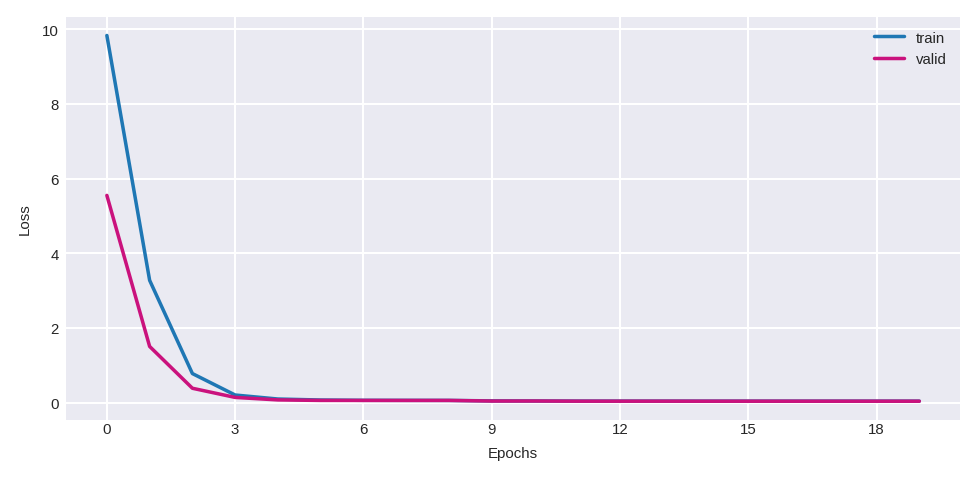

In [27]:
for cut_off_freq in range(15, 50, 5):
    print(f"cut_off_freq: {cut_off_freq}")
    results_dict={}
    for window_size in [1000]:#[125, 250, 500, 750, 1000]: #125, 250, 500, 750, 1000, 1250, 1500, 1750, 
        np.random.seed(SEED)
        tf.random.set_seed(SEED)
        print(f"Seed was set to: {SEED}")

        if str(window_size) not in results_dict:
            results_dict[str(window_size)]={}

        P.window_size=window_size
        P.nn_step_width = int(P.window_size * .5)
        P.ocsvm_step_width = int(P.window_size * .5)
        P.scaler = 'RobustScaler'


        P.SMA_per_win_winsize=None
        P.EMA_per_win_span=None
        P.Butter_per_win_argdict=None
        P.cut_off_freq=None
        P.span=None

        P.filter_order=4
        P.sampling_freq=100
        P.filtfilt=1
        P.cut_off_freq=30#cut_off_freq


    #     ffted_dfList_exp1 = get_ffted_dfList(dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)
    #     ffted_dfList_exp2 = get_ffted_dfList(dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)

    #     ffted_dfList_exp1_user_47 = get_ffted_dfList(dfList_exp1_user_47, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)
    #     ffted_dfList_exp2_user_47 = get_ffted_dfList(dfList_exp2_user_47, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)

    #     EMAed_dfList_exp1 = get_EMAed_dfList(raw_dfList_exp1, span=P.span)
    #     EMAed_dfList_exp2 = get_EMAed_dfList(raw_dfList_exp2, span=P.span)

    #     EMAed_dfList_exp1_user_47 = get_EMAed_dfList(raw_dfList_exp1_user_47, span=P.span)
    #     EMAed_dfList_exp2_user_47 = get_EMAed_dfList(raw_dfList_exp2_user_47, span=P.span)

    #     # preparing train data
    #     X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=get_raw_windows(EMAed_dfList_exp1, EMAed_dfList_exp2, window_size, step_width=P.nn_step_width, user_idx_set=train_set, scaler=P.scaler, 
    #                                                                                         num_sample_points_per_exp=P.num_sample_points_per_exp, 
    #                                                                                         EMA_per_win_span=P.EMA_per_win_span, 
    #                                                                                         SMA_per_win_winsize=P.SMA_per_win_winsize,
    #                                                                                         Butter_per_win_argdict=P.Butter_per_win_argdict, 
    #                                                                                         verbose=0)

    #     X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47=get_raw_windows_user_47(EMAed_dfList_exp1_user_47, EMAed_dfList_exp2_user_47, 
    #                                                                                                                         window_size, step_width=P.nn_step_width, scaler=P.scaler, 
    #                                                                                                                         num_sample_points_per_exp=P.num_sample_points_per_exp, 
    #                                                                                                                         EMA_per_win_span=P.EMA_per_win_span, 
    #                                                                                                                         SMA_per_win_winsize=P.SMA_per_win_winsize,
    #                                                                                                                         Butter_per_win_argdict=P.Butter_per_win_argdict, 
    #                                                                                                                         verbose=0)

    #     X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=append_user_47_to_data(X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict, P.user_ids, 
    #                                                                                                X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47, 
    #                                                                                                verbose=0)

        # preparing train data
    #     X_train_exp1_dict, X_train_exp2_dict, \
    #     fitted_scaler_train_exp2_dict, fitted_min_max_scaler_train_exp2_dict=get_raw_windows_NN(\
    #                                                                                             dfList_exp1=raw_dfList_exp1, 
    #                                                                                             dfList_exp2=raw_dfList_exp2, 
    #                                                                                             window_size=window_size, 
    #                                                                                             step_width=P.nn_step_width, 
    #                                                                                             user_idx_set=train_set, 
    #                                                                                             scaler=P.scaler, 
    #                                                                                             min_max_scaler=True,
    #                                                                                             num_sample_points_per_exp=P.num_sample_points_per_exp, 
    #                                                                                             EMA_per_win_span=P.EMA_per_win_span, 
    #                                                                                             SMA_per_win_winsize=P.SMA_per_win_winsize,
    #                                                                                             Butter_per_win_argdict=P.Butter_per_win_argdict, 
    #                                                                                             verbose=0)

    #     X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, \
    #     fitted_scaler_train_exp2_dict_user_47, \
    #     fitted_min_max_scaler_train_exp2_dict_user_47=get_raw_windows_user_47_NN(\
    #                                                                              dfList_exp1_user_47=raw_dfList_exp1_user_47, 
    #                                                                              dfList_exp2_user_47=raw_dfList_exp2_user_47, 
    #                                                                              window_size=window_size, 
    #                                                                              step_width=P.nn_step_width, 
    #                                                                              scaler=P.scaler, 
    #                                                                              min_max_scaler=True,
    #                                                                              num_sample_points_per_exp=P.num_sample_points_per_exp, 
    #                                                                              EMA_per_win_span=P.EMA_per_win_span, 
    #                                                                              SMA_per_win_winsize=P.SMA_per_win_winsize,
    #                                                                              Butter_per_win_argdict=P.Butter_per_win_argdict, 
    #                                                                              verbose=0)

    #     X_train_exp1_dict, X_train_exp2_dict, \
    #     fitted_scaler_train_exp2_dict, \
    #     fitted_min_max_scaler_train_exp2_dict=append_user_47_to_data_NN(\
    #                                                               X_exp1_dict=X_train_exp1_dict, 
    #                                                               X_exp2_dict=X_train_exp2_dict, 
    #                                                               fitted_scaler_exp2_dict=fitted_scaler_train_exp2_dict, 
    #                                                               all_user_set=P.user_ids, 
    #                                                               X_exp1_dict_user_47=X_train_exp1_dict_user_47, 
    #                                                               X_exp2_dict_user_47=X_train_exp2_dict_user_47, 
    #                                                               fitted_scaler_exp2_dict_user_47=fitted_scaler_train_exp2_dict_user_47, 
    #                                                               fitted_min_max_scaler_exp2_dict=fitted_min_max_scaler_train_exp2_dict, 
    #                                                               fitted_min_max_scaler_exp2_dict_user_47=fitted_min_max_scaler_train_exp2_dict_user_47,
    #                                                               verbose=0)


        ##butter
        ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)
        ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)

        ffted_dfList_exp1_user_47 = get_ffted_dfList(raw_dfList_exp1_user_47, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)
        ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)

        X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=get_raw_windows(dfList_exp1=ffted_dfList_exp1, 
                                                                                            dfList_exp2=ffted_dfList_exp2, 
                                                                                            window_size=window_size, 
                                                                                            step_width=P.nn_step_width, 
                                                                                            user_idx_set=train_set, 
                                                                                            scaler=P.scaler, 
                                                                                            num_sample_points_per_exp=P.num_sample_points_per_exp, 
                                                                                            EMA_per_win_span=P.EMA_per_win_span, 
                                                                                            SMA_per_win_winsize=P.SMA_per_win_winsize,
                                                                                            Butter_per_win_argdict=P.Butter_per_win_argdict, 
                                                                                            verbose=0)

        X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47=get_raw_windows_user_47(dfList_exp1_user_47=ffted_dfList_exp1_user_47, 
                                                                                                                            dfList_exp2_user_47=ffted_dfList_exp2_user_47, 
                                                                                                                            window_size=window_size, 
                                                                                                                            step_width=P.nn_step_width, 
                                                                                                                            scaler=P.scaler, 
                                                                                                                            num_sample_points_per_exp=P.num_sample_points_per_exp, 
                                                                                                                            EMA_per_win_span=P.EMA_per_win_span, 
                                                                                                                            SMA_per_win_winsize=P.SMA_per_win_winsize,
                                                                                                                            Butter_per_win_argdict=P.Butter_per_win_argdict, 
                                                                                                                            verbose=0)

        X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=append_user_47_to_data(X_exp1_dict=X_train_exp1_dict, 
                                                                                                   X_exp2_dict=X_train_exp2_dict, 
                                                                                                   fitted_scaler_exp2_dict=fitted_scaler_train_exp2_dict, 
                                                                                                   all_user_set=P.user_ids, 
                                                                                                   X_exp1_dict_user_47=X_train_exp1_dict_user_47, 
                                                                                                   X_exp2_dict_user_47=X_train_exp2_dict_user_47, 
                                                                                                   fitted_scaler_exp2_dict_user_47=fitted_scaler_train_exp2_dict_user_47, 
                                                                                                   verbose=0)


        ## butter

    #     ### main
    #     # preparing train data
    #     X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=get_raw_windows(dfList_exp1=raw_dfList_exp1, 
    #                                                                                         dfList_exp2=raw_dfList_exp2, 
    #                                                                                         window_size=window_size, 
    #                                                                                         step_width=P.nn_step_width, 
    #                                                                                         user_idx_set=train_set, 
    #                                                                                         scaler=P.scaler, 
    #                                                                                         num_sample_points_per_exp=P.num_sample_points_per_exp, 
    #                                                                                         EMA_per_win_span=P.EMA_per_win_span, 
    #                                                                                         SMA_per_win_winsize=P.SMA_per_win_winsize,
    #                                                                                         Butter_per_win_argdict=P.Butter_per_win_argdict, 
    #                                                                                         verbose=0)

    #     X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47=get_raw_windows_user_47(dfList_exp1_user_47=raw_dfList_exp1_user_47, 
    #                                                                                                                         dfList_exp2_user_47=raw_dfList_exp2_user_47, 
    #                                                                                                                         window_size=window_size, 
    #                                                                                                                         step_width=P.nn_step_width, 
    #                                                                                                                         scaler=P.scaler, 
    #                                                                                                                         num_sample_points_per_exp=P.num_sample_points_per_exp, 
    #                                                                                                                         EMA_per_win_span=P.EMA_per_win_span, 
    #                                                                                                                         SMA_per_win_winsize=P.SMA_per_win_winsize,
    #                                                                                                                         Butter_per_win_argdict=P.Butter_per_win_argdict, 
    #                                                                                                                         verbose=0)

    #     X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=append_user_47_to_data(X_exp1_dict=X_train_exp1_dict, 
    #                                                                                                X_exp2_dict=X_train_exp2_dict, 
    #                                                                                                fitted_scaler_exp2_dict=fitted_scaler_train_exp2_dict, 
    #                                                                                                all_user_set=P.user_ids, 
    #                                                                                                X_exp1_dict_user_47=X_train_exp1_dict_user_47, 
    #                                                                                                X_exp2_dict_user_47=X_train_exp2_dict_user_47, 
    #                                                                                                fitted_scaler_exp2_dict_user_47=fitted_scaler_train_exp2_dict_user_47, 
    #                                                                                                verbose=0)

    #     ### end main

#         ##butter
#         ffted_dfList_exp3 = get_ffted_dfList(raw_dfList_exp3, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)
#         ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)

#         ffted_dfList_exp3_user_47 = get_ffted_dfList(raw_dfList_exp3_user_47, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)
#         ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)
        
#         ### new
#         # preparing train data
#         X_train_exp30_dict, X_train_exp23_dict, fitted_scaler_train_exp23_dict=get_raw_windows(\
#                                                                                                dfList_exp1=raw_dfList_exp3, 
#                                                                                                dfList_exp2=raw_dfList_exp2, 
#                                                                                                window_size=window_size, 
#                                                                                                step_width=P.nn_step_width, 
#                                                                                                user_idx_set=filterred_train_set_arr_exp3, 
#                                                                                                scaler=P.scaler, 
#                                                                                                num_sample_points_per_exp=6000, 
#                                                                                                EMA_per_win_span=P.EMA_per_win_span, 
#                                                                                                SMA_per_win_winsize=P.SMA_per_win_winsize,
#                                                                                                Butter_per_win_argdict=P.Butter_per_win_argdict, 
#                                                                                                verbose=0)


#         ### end new




        spliter = 2*len(X_train_exp2_dict)//3
        cnn_train_exp2 = {key: X_train_exp2_dict[key] for key in list(X_train_exp2_dict.keys())[:spliter]}
        cnn_train_exp1 = {key: X_train_exp1_dict[key] for key in list(X_train_exp1_dict.keys())[:spliter]}
        cnn_valid_exp2 = {key: X_train_exp2_dict[key] for key in list(X_train_exp2_dict.keys())[spliter:]}
        cnn_valid_exp1 = {key: X_train_exp1_dict[key] for key in list(X_train_exp1_dict.keys())[spliter:]}


        # #### new
        # cnn_train_exp23 = {key: X_train_exp23_dict[key] for key in list(X_train_exp23_dict.keys())[:spliter-1]}
        # cnn_train_exp30 = {key: X_train_exp30_dict[key] for key in list(X_train_exp30_dict.keys())[:spliter-1]}
        # cnn_valid_exp23 = {key: X_train_exp23_dict[key] for key in list(X_train_exp23_dict.keys())[spliter-1:]}
        # cnn_valid_exp30 = {key: X_train_exp30_dict[key] for key in list(X_train_exp30_dict.keys())[spliter-1:]}
        # #### end new

    #     train_pairs_dict = prep_X_y_pair_robust_minmax(cnn_train_exp2, cnn_train_exp1, list(cnn_train_exp2.keys()), 
    #                                                    fitted_raw_Robust_scaler_dict=fitted_scaler_train_exp2_dict, 
    #                                                    num_pair_limit=2*NUM_PAIR_LIMIT_TRAIN_2000)
    #     #(2*num_samples)//3)
    #     X_train, y_train, X_train_distro_dic = train_pairs_dict["X"], train_pairs_dict["y"], train_pairs_dict["X_dic"]

    #     valid_pairs_dict = prep_X_y_pair_robust_minmax(cnn_valid_exp2, cnn_valid_exp1, list(cnn_valid_exp2.keys()), 
    #                                                    fitted_raw_Robust_scaler_dict=fitted_scaler_train_exp2_dict, 
    #                                                    num_pair_limit=2*NUM_PAIR_LIMIT_VALID_2000)
    #     #num_samples//3)
    #     X_valid, y_valid, X_valid_distro_dic = valid_pairs_dict["X"], valid_pairs_dict["y"], valid_pairs_dict["X_dic"]


        # # using -1 samples
        print("using flipped data")
        train_pairs_dict = prep_X_y_pair_robust_minmax(X_exp2_dic=cnn_train_exp2, 
                                                       X_exp1_dic=cnn_train_exp1, 
                                                       user_id_list=list(cnn_train_exp2.keys()), 
                                                       fitted_raw_Robust_scaler_dict=fitted_scaler_train_exp2_dict, 
                                                       is_train=True,
                                                       # 2X the sample size as each window makes another flipped sign window
                                                       num_pair_limit=2*NUM_PAIR_LIMIT_TRAIN_2000)

        # print("NOT using flipped data")
        # train_pairs_dict = prep_X_y_pair_robust_minmax(X_exp2_dic=cnn_train_exp2, 
        #                                                X_exp1_dic=cnn_train_exp1, 
        #                                                user_id_list=list(cnn_train_exp2.keys()), 
        #                                                fitted_raw_Robust_scaler_dict=fitted_scaler_train_exp2_dict, 
        #                                                is_train=False,
        #                                                num_pair_limit=2*NUM_PAIR_LIMIT_TRAIN_2000)

        X_train, y_train, X_train_distro_dic = train_pairs_dict["X"], train_pairs_dict["y"], train_pairs_dict["X_dic"]

        valid_pairs_dict = prep_X_y_pair_robust_minmax(X_exp2_dic=cnn_valid_exp2, 
                                                       X_exp1_dic=cnn_valid_exp1, 
                                                       user_id_list=list(cnn_valid_exp2.keys()), 
                                                       fitted_raw_Robust_scaler_dict=fitted_scaler_train_exp2_dict, 
                                                       is_train=False,
                                                       num_pair_limit=NUM_PAIR_LIMIT_VALID_2000)

        X_valid, y_valid, X_valid_distro_dic = valid_pairs_dict["X"], valid_pairs_dict["y"], valid_pairs_dict["X_dic"]
        # using -1 samples


#         ##### new
#         train_pairs_dict = prep_X_y_pair_robust_minmax(cnn_train_exp23, cnn_train_exp30, list(cnn_train_exp23.keys()), 
#                                                        fitted_raw_Robust_scaler_dict=fitted_scaler_train_exp23_dict, 
#                                                        is_train=True,
#                                                        num_pair_limit=2*NUM_PAIR_LIMIT_TRAIN_2000)


#         X_train23, y_train23 = train_pairs_dict["X"], train_pairs_dict["y"]

#         valid_pairs_dict = prep_X_y_pair_robust_minmax(cnn_valid_exp23, cnn_valid_exp30, list(cnn_valid_exp23.keys()), 
#                                                        fitted_raw_Robust_scaler_dict=fitted_scaler_train_exp23_dict, 
#                                                        is_train=False,
#                                                        num_pair_limit=2*NUM_PAIR_LIMIT_VALID_2000)


#         X_valid23, y_valid23 = valid_pairs_dict["X"], valid_pairs_dict["y"]

#         X_left = np.concatenate([X_train[0], X_train23[0]])
#         X_right = np.concatenate([X_train[1], X_train23[1]])
#         y_train = np.concatenate([y_train, y_train23])

#         X_left, X_right, y_train = sklearn_shuffle(X_left, X_right, y_train, random_state=SEED)

#         X_train = [X_left, X_right]



#         X_left = np.concatenate([X_valid[0], X_valid23[0]])
#         X_right = np.concatenate([X_valid[1], X_valid23[1]])
#         y_valid = np.concatenate([y_valid, y_valid23])

#         X_left, X_right, y_valid = sklearn_shuffle(X_left, X_right, y_valid, random_state=SEED)

#         X_valid = [X_left, X_right]

#         ##### end new


        # X_final_train, y_train = prep_X_y_pair(X_train_exp2_dict, X_train_exp1_dict, list(X_train_exp2_dict.keys()), fitted_scaler_train_exp2_dict, num_pair_limit=num_pair_limit_train_2000)

        # 2D Filter Model needs flat 4th dimension
        if P.model_variant == "2d":
            X_train[0] = X_train[0].reshape((*X_train[0].shape, 1))
            X_train[1] = X_train[1].reshape((*X_train[1].shape, 1))
            X_valid[0] = X_valid[0].reshape((*X_valid[0].shape, 1))
            X_valid[1] = X_valid[1].reshape((*X_valid[1].shape, 1))

        print(
            f"Training samples:   {y_train.shape[0]}, shape: {X_train[0].shape},"
            + f" class balance: {np.unique(y_train, return_counts=True)}"
        )
        print(
            f"Validation samples: {y_valid.shape[0]}, shape: {X_valid[0].shape},"
            + f" class balance: {np.unique(y_valid, return_counts=True)}"
        )
        data_dict = {}
        data_dict["X_valid"], data_dict["y_valid"], data_dict["X_train"], data_dict["y_train"] = X_valid, y_valid, X_train, y_train


    #     X_left = np.concatenate([X_train[0], X_valid[0]])
    #     X_right = np.concatenate([X_train[1], X_valid[1]])
    #     y_train_valid = np.concatenate([y_train, y_valid])

    #     X_left, X_right, y_train_valid = sklearn_shuffle(X_left, X_right, y_train_valid, random_state=SEED)

    #     X_train_valid = [X_left, X_right]





        report_dict={    
            "Training_samples": str(np.unique(y_train, return_counts=True)),
            "Validation_samples": str(np.unique(y_valid, return_counts=True)),
            "smoothing": P.smoothing if P.smoothing!=None else None,
            # "EMA_span": P.span if "EMA" in P.smoothing else None ,
            "Butter_cut_off_freq": P.cut_off_freq if P.cut_off_freq!=None else P.cut_off_freq,
            "scaler": P.scaler,
        }

        for arg_dict_name in cnn_arch_dict:
            if arg_dict_name not in results_dict[str(window_size)]:
                np.random.seed(SEED)
                tf.random.set_seed(SEED)
                print(arg_dict_name)
                arg_dict=cnn_arch_dict[arg_dict_name]


                create_model_func = get_create_model_func(P.model_variant, P.window_size, P.feature_cols)

                arg_dict["optimizer_lr"]=0.001
                arg_dict["batch_size"]=256
                arg_dict["contrastive_loss_margin"]=.5
                arg_dict["optimizer_name"]="Adam"

    #             if 1250>window_size>750:
    #                 # arg_dict["batch_size"]=256
    #                 # arg_dict["optimizer_lr"]=0.001
    #                 arg_dict["batch_size"]=256
    #                 arg_dict["optimizer_lr"]=0.001

    #             elif  1500>=window_size>=1250:
    #                 arg_dict["batch_size"]=128
    #                 arg_dict["optimizer_lr"]=0.001

    #             elif window_size>1500:
    #                 arg_dict["batch_size"]=64
    #                 arg_dict["optimizer_lr"]=0.0001


                # arg_dict["optimizer_lr"]=0.0001

                lr_epoch_log_dict={}
                ReduceLROnPlateau_args={'mointored_metric': "val_loss", "factor": 0.2, "patience": 1, "verbose": 1, "min_lr": 1e-6}
                # ReduceLROnPlateau_args={'mointored_metric': "val_loss", "factor": 0.5, "patience": 2, "verbose": 1, "min_lr": 1e-6}

                print(arg_dict["optimizer_lr"])
                print(arg_dict)
                loss_record_dict = {'loss': [], 'val_loss': []}
                metric_record_dict = {}
                model = create_model_func(arg_dict)

                # Train
                history = model.fit(
                    x=X_train,
                    y=y_train,
                    batch_size=arg_dict["batch_size"],
                    epochs=20,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    shuffle=True,
                    callbacks=[MetricsCallback((X_valid, y_valid, X_train, y_train), epoch_evaluate_freq=1, 
                                               loss_record_dict=loss_record_dict, metric_record_dict=metric_record_dict, 
                                               save_plots=True, print_interm_epochs=True, early_stoping=False,
                                               ReduceLROnPlateau_args=ReduceLROnPlateau_args, lr_epoch_log_dict=lr_epoch_log_dict)]#, reduce_lr],
                )
                print(loss_record_dict)
                print("Training History:")
                loss_fig = utils_plot_training_loss(loss_record_dict)

                results_dict[str(window_size)][arg_dict_name]={
                                                        "lr_epoch_log_dict": str(lr_epoch_log_dict),
                                                        "loss_record_dict": loss_record_dict,
                                                        "metric_record_dict": metric_record_dict,
                                                        "report_dict": report_dict,
                                                        "ReduceLROnPlateau_args": ReduceLROnPlateau_args,
                                                        "arg_dict": arg_dict,
                }

                save_training_config_dict(f"{window_size}-{arg_dict_name}")
                del model
                del history
                K.clear_session()
                tf.compat.v1.reset_default_graph()

In [ ]:
# .5 epoch
81/81 [==============================] - 4s 44ms/step - loss: 0.0270 - val_loss: 0.0346
================================[   Epoch 9   ]================================
TRAIN: roc_auc: 0.9761, eer: 0.0768, thres: 0.1995 => acc: 0.9232, f1: 0.9233
loss: 0.027, val_loss: 0.035

VALID: roc_auc: 0.9432, eer: 0.1507, thres: 0.2885 => acc: 0.8493, f1: 0.8492
loss: 0.027, val_loss: 0.035
Epoch 11/20

In [ ]:
# average poling
Epoch 11/11
171/171 [==============================] - 7s 43ms/step - loss: 0.0611 - val_loss: 0.1359
================================[   Epoch 10   ]================================
TRAIN: roc_auc: 0.9939, eer: 0.0370, thres: 0.4411 => acc: 0.9630, f1: 0.9630
loss: 0.061, val_loss: 0.136

VALID: roc_auc: 0.9191, eer: 0.1722, thres: 0.4860 => acc: 0.8278, f1: 0.8278
loss: 0.061, val_loss: 0.136

# the following were all with max pooling
# tanh stopped too early, maybe try again later
171/171 [==============================] - 8s 46ms/step - loss: 0.0640 - val_loss: 0.1398
================================[   Epoch 6   ]================================
TRAIN: roc_auc: 0.9938, eer: 0.0347, thres: 0.4186 => acc: 0.9653, f1: 0.9653
loss: 0.064, val_loss: 0.140

VALID: roc_auc: 0.9048, eer: 0.1929, thres: 0.4396 => acc: 0.8071, f1: 0.8071
loss: 0.064, val_loss: 0.140
Epoch 8/11

# linear with he normal and .1 input droput
171/171 [==============================] - 7s 39ms/step - loss: 0.0650 - val_loss: 0.1223
================================[   Epoch 11   ]================================
TRAIN: roc_auc: 0.9960, eer: 0.0315, thres: 0.4199 => acc: 0.9685, f1: 0.9685
loss: 0.065, val_loss: 0.122

VALID: roc_auc: 0.9445, eer: 0.1338, thres: 0.5698 => acc: 0.8662, f1: 0.8662
loss: 0.065, val_loss: 0.122
Epoch 13/30

# relu with he normal works better:
171/171 [==============================] - 7s 42ms/step - loss: 0.0714 - val_loss: 0.1072
================================[   Epoch 6   ]================================
TRAIN: roc_auc: 0.9772, eer: 0.0763, thres: 0.4146 => acc: 0.9237, f1: 0.9237
loss: 0.071, val_loss: 0.107

VALID: roc_auc: 0.9639, eer: 0.0990, thres: 0.5798 => acc: 0.9010, f1: 0.9010
loss: 0.071, val_loss: 0.107
Epoch 8/30

# sigmoid wins vs relu both glorot normal
171/171 [==============================] - 8s 45ms/step - loss: 0.0546 - val_loss: 0.1042
================================[   Epoch 11   ]================================
TRAIN: roc_auc: 0.9968, eer: 0.0277, thres: 0.4133 => acc: 0.9723, f1: 0.9723
loss: 0.055, val_loss: 0.104

VALID: roc_auc: 0.9606, eer: 0.1138, thres: 0.4263 => acc: 0.8863, f1: 0.8863
loss: 0.055, val_loss: 0.104
Epoch 13/30

# relu with glorot normla
================================[   Epoch 7   ]================================
TRAIN: roc_auc: 0.9873, eer: 0.0521, thres: 0.4474 => acc: 0.9479, f1: 0.9479
loss: 0.064, val_loss: 0.137

VALID: roc_auc: 0.9472, eer: 0.1192, thres: 0.5647 => acc: 0.8808, f1: 0.8808
loss: 0.064, val_loss: 0.137

In [ ]:
K.clear_session()

tf.compat.v1.reset_default_graph()

In [ ]:
K.clear_session()

tf.compat.v1.reset_default_graph()
    
# with -1 and with droput .5
81/81 [==============================] - 3s 43ms/step - loss: 0.0851 - val_loss: 0.1162
================================[   Epoch 4   ]================================
TRAIN: roc_auc: 0.9777, eer: 0.0733, thres: 0.3914 => acc: 0.9267, f1: 0.9269
loss: 0.085, val_loss: 0.116

VALID: roc_auc: 0.9397, eer: 0.1585, thres: 0.3132 => acc: 0.8417, f1: 0.8415
loss: 0.085, val_loss: 0.116
Epoch 6/30
81/81 [=========================
       
# without -1 samples
================================[   Epoch 8   ]================================
TRAIN: roc_auc: 0.9954, eer: 0.0231, thres: 0.3856 => acc: 0.9769, f1: 0.9769
loss: 0.049, val_loss: 0.112

VALID: roc_auc: 0.9413, eer: 0.1496, thres: 0.4100 => acc: 0.8504, f1: 0.8502
loss: 0.049, val_loss: 0.112
Epoch 10/30

In [ ]:
results_dict={}
if str(window_size) not in results_dict:
    results_dict[str(window_size)]={}
for arg_dict_name in cnn_arch_dict:
    if arg_dict_name not in results_dict[str(window_size)]:
        np.random.seed(SEED)
        tf.random.set_seed(SEED)
        print(arg_dict_name)
        arg_dict=cnn_arch_dict[arg_dict_name]


        create_model_func = get_create_model_func(P.model_variant, P.window_size, P.feature_cols)

        arg_dict["optimizer_lr"]=0.0001
        arg_dict["batch_size"]=32
        arg_dict["contrastive_loss_margin"]=1.0
        arg_dict["optimizer_name"]="Adam"

#             if 1250>window_size>750:
#                 # arg_dict["batch_size"]=256
#                 # arg_dict["optimizer_lr"]=0.001
#                 arg_dict["batch_size"]=256
#                 arg_dict["optimizer_lr"]=0.001

#             elif  1500>=window_size>=1250:
#                 arg_dict["batch_size"]=128
#                 arg_dict["optimizer_lr"]=0.001

#             elif window_size>1500:
#                 arg_dict["batch_size"]=64
#                 arg_dict["optimizer_lr"]=0.0001


        # arg_dict["optimizer_lr"]=0.0001

        lr_epoch_log_dict={}
        ReduceLROnPlateau_args={'mointored_metric': "val_loss", "factor": 0.2, "patience": 5, "verbose": 1, "min_lr": 1e-6}
        # ReduceLROnPlateau_args={'mointored_metric': "val_loss", "factor": 0.5, "patience": 2, "verbose": 1, "min_lr": 1e-6}

        print(arg_dict["optimizer_lr"])
        print(arg_dict)
        loss_record_dict = {'loss': [], 'val_loss': []}
        metric_record_dict = {}
        model = create_model_func(arg_dict)

        # Train
        history = model.fit(
            x=X_train,
            y=y_train,
            batch_size=arg_dict["batch_size"],
            epochs=30,
            verbose=1,
            validation_data=(X_valid, y_valid),
            shuffle=True,
            callbacks=[MetricsCallback((X_valid, y_valid, X_train, y_train), epoch_evaluate_freq=1, 
                                       loss_record_dict=loss_record_dict, metric_record_dict=metric_record_dict, 
                                       save_plots=True, print_interm_epochs=True, early_stoping=False,
                                       ReduceLROnPlateau_args=ReduceLROnPlateau_args, lr_epoch_log_dict=lr_epoch_log_dict)]#, reduce_lr],
        )
        print(loss_record_dict)
        print("Training History:")
        loss_fig = utils_plot_training_loss(loss_record_dict)

        results_dict[str(window_size)][arg_dict_name]={
                                                "lr_epoch_log_dict": str(lr_epoch_log_dict),
                                                "loss_record_dict": loss_record_dict,
                                                "metric_record_dict": metric_record_dict,
                                                "report_dict": report_dict,
                                                "ReduceLROnPlateau_args": ReduceLROnPlateau_args,
                                                "arg_dict": arg_dict,
        }

        save_training_config_dict(f"{window_size}-{arg_dict_name}")
        del model
        del history
        K.clear_session()
        tf.compat.v1.reset_default_graph()

In [ ]:
# l1 of 0.0005
================================[   Epoch 15   ]================================
TRAIN: roc_auc: 0.9955, eer: 0.0274, thres: 0.3949 => acc: 0.9727, f1: 0.9728
loss: 0.075, val_loss: 0.101

VALID: roc_auc: 0.9752, eer: 0.0732, thres: 0.4997 => acc: 0.9268, f1: 0.9267
loss: 0.075, val_loss: 0.101
Epoch 17/30

#max constraint =1
81/81 [==============================] - 3s 42ms/step - loss: 0.0604 - val_loss: 0.1004
================================[   Epoch 11   ]================================
TRAIN: roc_auc: 0.9960, eer: 0.0235, thres: 0.4180 => acc: 0.9765, f1: 0.9765
loss: 0.060, val_loss: 0.100

VALID: roc_auc: 0.9661, eer: 0.0952, thres: 0.5121 => acc: 0.9048, f1: 0.9047
loss: 0.060, val_loss: 0.100

# l2 = 0.0005 wtih .2 dropout max constraint 3
81/81 [==============================] - 4s 44ms/step - loss: 0.0626 - val_loss: 0.1008
================================[   Epoch 11   ]================================
TRAIN: roc_auc: 0.9958, eer: 0.0230, thres: 0.4229 => acc: 0.9769, f1: 0.9770
loss: 0.063, val_loss: 0.101

VALID: roc_auc: 0.9682, eer: 0.0897, thres: 0.5148 => acc: 0.9103, f1: 0.9102
loss: 0.063, val_loss: 0.101

# l2 = 0.0005 wtih .2 dropout
================================[   Epoch 11   ]================================
TRAIN: roc_auc: 0.9958, eer: 0.0247, thres: 0.4053 => acc: 0.9753, f1: 0.9754
loss: 0.064, val_loss: 0.099

VALID: roc_auc: 0.9679, eer: 0.0910, thres: 0.4796 => acc: 0.9091, f1: 0.9090
loss: 0.064, val_loss: 0.099
Epoch 13/30

# l2 = 0.001 wtih .2 dropout
================================[   Epoch 11   ]================================
TRAIN: roc_auc: 0.9957, eer: 0.0260, thres: 0.4132 => acc: 0.9740, f1: 0.9740
loss: 0.064, val_loss: 0.102

VALID: roc_auc: 0.9644, eer: 0.0935, thres: 0.4823 => acc: 0.9065, f1: 0.9064
loss: 0.064, val_loss: 0.102
Epoch 13/30

#manhattan l2=0.1
81/81 [==============================] - 3s 38ms/step - loss: 0.0823 - val_loss: 0.0964
================================[   Epoch 15   ]================================
TRAIN: roc_auc: 0.9802, eer: 0.0677, thres: 0.3879 => acc: 0.9321, f1: 0.9323
loss: 0.082, val_loss: 0.096

VALID: roc_auc: 0.9731, eer: 0.0904, thres: 0.6025 => acc: 0.9095, f1: 0.9094
loss: 0.082, val_loss: 0.096

# manhattan l2=0.01
81/81 [==============================] - 3s 43ms/step - loss: 0.0542 - val_loss: 0.1062
================================[   Epoch 13   ]================================
TRAIN: roc_auc: 0.9962, eer: 0.0233, thres: 0.4390 => acc: 0.9767, f1: 0.9768
loss: 0.054, val_loss: 0.106

VALID: roc_auc: 0.9600, eer: 0.1071, thres: 0.5374 => acc: 0.8928, f1: 0.8927
loss: 0.054, val_loss: 0.106
Epoch 15/30

# manhattan l2=0.001
81/81 [==============================] - 3s 36ms/step - loss: 0.0538 - val_loss: 0.1149
================================[   Epoch 14   ]================================
TRAIN: roc_auc: 0.9986, eer: 0.0162, thres: 0.4246 => acc: 0.9838, f1: 0.9838
loss: 0.054, val_loss: 0.115

VALID: roc_auc: 0.9536, eer: 0.1121, thres: 0.5310 => acc: 0.8879, f1: 0.8878
loss: 0.054, val_loss: 0.115
Epoch 16/30

#manhattan l2=0.0001
81/81 [==============================] - 3s 42ms/step - loss: 0.0841 - val_loss: 0.0993
================================[   Epoch 2   ]================================
TRAIN: roc_auc: 0.9779, eer: 0.0705, thres: 0.3093 => acc: 0.9295, f1: 0.9296
loss: 0.084, val_loss: 0.099

VALID: roc_auc: 0.9639, eer: 0.1030, thres: 0.4808 => acc: 0.8970, f1: 0.8969
loss: 0.084, val_loss: 0.099
Epoch 4/30
81/81 [======================

================================[   Epoch 13   ]================================
TRAIN: roc_auc: 0.9937, eer: 0.0339, thres: 0.4101 => acc: 0.9661, f1: 0.9662
loss: 0.064, val_loss: 0.108

VALID: roc_auc: 0.9538, eer: 0.1208, thres: 0.5487 => acc: 0.8789, f1: 0.8788
loss: 0.064, val_loss: 0.108
Epoch 15/30


# euclideain no reg
================================[   Epoch 23   ]================================
TRAIN: roc_auc: 0.9971, eer: 0.0186, thres: 0.3852 => acc: 0.9814, f1: 0.9815
loss: 0.040, val_loss: 0.088

VALID: roc_auc: 0.9728, eer: 0.0759, thres: 0.5412 => acc: 0.9242, f1: 0.9241
loss: 0.040, val_loss: 0.088

Epoch 24: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

# manhattan no reg
===============================[   Epoch 1   ]================================
TRAIN: roc_auc: 0.9126, eer: 0.1571, thres: 0.2605 => acc: 0.8429, f1: 0.8432
loss: 0.147, val_loss: 0.140

VALID: roc_auc: 0.9143, eer: 0.1628, thres: 0.3754 => acc: 0.8373, f1: 0.8371
loss: 0.147, val_loss: 0.140
Epoch 3/30

# minkp=5 and no regulariztion
================================[   Epoch 15   ]================================
TRAIN: roc_auc: 0.9986, eer: 0.0145, thres: 0.3754 => acc: 0.9855, f1: 0.9856
loss: 0.040, val_loss: 0.077

VALID: roc_auc: 0.9797, eer: 0.0705, thres: 0.4651 => acc: 0.9294, f1: 0.9293
loss: 0.040, val_loss: 0.077

# increase all filter sizes to 64 # dropout =.3 and l2=.05
================================[   Epoch 9   ]================================
TRAIN: roc_auc: 0.9894, eer: 0.0432, thres: 0.3875 => acc: 0.9567, f1: 0.9568
loss: 0.081, val_loss: 0.082

VALID: roc_auc: 0.9810, eer: 0.0601, thres: 0.5036 => acc: 0.9399, f1: 0.9398
loss: 0.081, val_loss: 0.082

# increase all filter sizes to 64 # dropout =.3 and l2=.05
================================[   Epoch 15   ]================================
TRAIN: roc_auc: 0.9847, eer: 0.0574, thres: 0.4115 => acc: 0.9426, f1: 0.9427
loss: 0.080, val_loss: 0.083

VALID: roc_auc: 0.9786, eer: 0.0684, thres: 0.5358 => acc: 0.9316, f1: 0.9315
loss: 0.080, val_loss: 0.083
Epoch 17/30

# incrased FC layer to 64:
================================[   Epoch 16   ]================================
TRAIN: roc_auc: 0.9815, eer: 0.0623, thres: 0.4021 => acc: 0.9377, f1: 0.9378
loss: 0.081, val_loss: 0.094

VALID: roc_auc: 0.9708, eer: 0.0755, thres: 0.5588 => acc: 0.9246, f1: 0.9245
loss: 0.081, val_loss: 0.094

# dropout =.3 and l2=.05
================================[   Epoch 20   ]================================
TRAIN: roc_auc: 0.9822, eer: 0.0622, thres: 0.4002 => acc: 0.9378, f1: 0.9379
loss: 0.081, val_loss: 0.086

VALID: roc_auc: 0.9733, eer: 0.0741, thres: 0.4901 => acc: 0.9260, f1: 0.9259
loss: 0.081, val_loss: 0.086
Epoch 22/30

# dropout =.3 and l2=.5
================================[   Epoch 19   ]================================
TRAIN: roc_auc: 0.9685, eer: 0.0839, thres: 0.3605 => acc: 0.9160, f1: 0.9161
loss: 0.095, val_loss: 0.091

VALID: roc_auc: 0.9695, eer: 0.0752, thres: 0.5575 => acc: 0.9248, f1: 0.9247
loss: 0.095, val_loss: 0.091

# dropout =.3 and l2=.1
================================[   Epoch 21   ]================================
TRAIN: roc_auc: 0.9811, eer: 0.0643, thres: 0.3994 => acc: 0.9357, f1: 0.9358
loss: 0.083, val_loss: 0.083

VALID: roc_auc: 0.9772, eer: 0.0716, thres: 0.4914 => acc: 0.9284, f1: 0.9283
loss: 0.083, val_loss: 0.083
Epoch 23/30

## l2=0.1 filter_order 3
================================[   Epoch 14   ]================================
TRAIN: roc_auc: 0.9766, eer: 0.0738, thres: 0.3707 => acc: 0.9262, f1: 0.9263
loss: 0.092, val_loss: 0.082

VALID: roc_auc: 0.9774, eer: 0.0675, thres: 0.4929 => acc: 0.9326, f1: 0.9325
loss: 0.092, val_loss: 0.082

# # # with butter 15 with negative samples moved drop out after pooling only avg pooling poolsize 2 with temporal attention
81/81 [==============================] - 5s 59ms/step - loss: 0.0905 - val_loss: 0.0822
================================[   Epoch 6   ]================================
TRAIN: roc_auc: 0.9766, eer: 0.0762, thres: 0.3806 => acc: 0.9238, f1: 0.9240
loss: 0.091, val_loss: 0.082

VALID: roc_auc: 0.9793, eer: 0.0716, thres: 0.5249 => acc: 0.9284, f1: 0.9283
loss: 0.091, val_loss: 0.082
Epoch 8/30

# # with butter 15 with negative samples moved drop out after pooling only avg pooling poolsize 3
===============================[   Epoch 11   ]================================
TRAIN: roc_auc: 0.9796, eer: 0.0678, thres: 0.3878 => acc: 0.9322, f1: 0.9324
loss: 0.085, val_loss: 0.079

VALID: roc_auc: 0.9801, eer: 0.0716, thres: 0.4686 => acc: 0.9284, f1: 0.9283
loss: 0.085, val_loss: 0.079


# # with butter 15 with negative samples moved drop out after pooling only no pooling
81/81 [==============================] - 3s 40ms/step - loss: 0.0794 - val_loss: 0.0810
================================[   Epoch 11   ]================================
TRAIN: roc_auc: 0.9853, eer: 0.0537, thres: 0.3974 => acc: 0.9463, f1: 0.9464
loss: 0.079, val_loss: 0.081

VALID: roc_auc: 0.9807, eer: 0.0670, thres: 0.5010 => acc: 0.9331, f1: 0.9330
loss: 0.079, val_loss: 0.081

# # with butter 15 with negative samples moved drop out after pooling only avg + max pool
================================[   Epoch 8   ]================================
TRAIN: roc_auc: 0.9890, eer: 0.0480, thres: 0.3800 => acc: 0.9521, f1: 0.9522
loss: 0.078, val_loss: 0.096

VALID: roc_auc: 0.9696, eer: 0.0814, thres: 0.5141 => acc: 0.9186, f1: 0.9185
loss: 0.078, val_loss: 0.096
Epoch 10/30
81/81 [==================

# # with butter 15 with negative samples moved drop out after pooling only avg + min pool
================================[   Epoch 5   ]================================
TRAIN: roc_auc: 0.9864, eer: 0.0532, thres: 0.3316 => acc: 0.9469, f1: 0.9470
loss: 0.087, val_loss: 0.098

VALID: roc_auc: 0.9668, eer: 0.1006, thres: 0.5468 => acc: 0.8993, f1: 0.8992
loss: 0.087, val_loss: 0.098
Epoch 7/30

# # with butter 15 with negative samples moved drop out after pooling only min pool
81/81 [==============================] - 3s 39ms/step - loss: 0.0753 - val_loss: 0.0868
================================[   Epoch 11   ]================================
TRAIN: roc_auc: 0.9887, eer: 0.0485, thres: 0.3601 => acc: 0.9516, f1: 0.9517
loss: 0.075, val_loss: 0.087

VALID: roc_auc: 0.9785, eer: 0.0773, thres: 0.5312 => acc: 0.9227, f1: 0.9226
loss: 0.075, val_loss: 0.087

# # with butter 15 with negative samples moved drop out after pooling only avg pool
================================[   Epoch 11   ]================================
TRAIN: roc_auc: 0.9829, eer: 0.0623, thres: 0.3981 => acc: 0.9377, f1: 0.9379
loss: 0.083, val_loss: 0.076

VALID: roc_auc: 0.9807, eer: 0.0634, thres: 0.4825 => acc: 0.9365, f1: 0.9364
loss: 0.083, val_loss: 0.076
Epoch 13/30

# # with butter 15 with negative samples moved drop out after pooling only max pool
================================[   Epoch 7   ]================================
TRAIN: roc_auc: 0.9892, eer: 0.0488, thres: 0.3304 => acc: 0.9513, f1: 0.9514
loss: 0.081, val_loss: 0.096

VALID: roc_auc: 0.9685, eer: 0.0898, thres: 0.4805 => acc: 0.9102, f1: 0.9101
loss: 0.081, val_loss: 0.096
Epoch 9/30

# # with butter 15 with negative samples moved drop out after pooling
================================[   Epoch 8   ]================================
TRAIN: roc_auc: 0.9879, eer: 0.0555, thres: 0.3586 => acc: 0.9445, f1: 0.9447
loss: 0.076, val_loss: 0.105

VALID: roc_auc: 0.9609, eer: 0.1021, thres: 0.5146 => acc: 0.8980, f1: 0.8979
loss: 0.076, val_loss: 0.105
Epoch 10/30

# with butter 15 with negative samples
81/81 [==============================] - 4s 54ms/step - loss: 0.0597 - val_loss: 0.1127
================================[   Epoch 6   ]================================
TRAIN: roc_auc: 0.9749, eer: 0.0812, thres: 0.2448 => acc: 0.9188, f1: 0.9190
loss: 0.060, val_loss: 0.113

VALID: roc_auc: 0.9718, eer: 0.0776, thres: 0.3526 => acc: 0.9223, f1: 0.9223
loss: 0.060, val_loss: 0.113
Epoch 8/30

# with butter 20 with negative samples
================================[   Epoch 6   ]================================
TRAIN: roc_auc: 0.9787, eer: 0.0738, thres: 0.2351 => acc: 0.9262, f1: 0.9263
loss: 0.060, val_loss: 0.123

VALID: roc_auc: 0.9671, eer: 0.0844, thres: 0.3256 => acc: 0.9156, f1: 0.9155
loss: 0.060, val_loss: 0.123
Epoch 8/30

# with butter 30 with negative samples
================================[   Epoch 11   ]================================
TRAIN: roc_auc: 0.9792, eer: 0.0749, thres: 0.2328 => acc: 0.9251, f1: 0.9253
loss: 0.051, val_loss: 0.141

VALID: roc_auc: 0.9393, eer: 0.1247, thres: 0.2841 => acc: 0.8754, f1: 0.8752
loss: 0.051, val_loss: 0.141

# with butter 40 with negative samples
================================[   Epoch 17   ]================================
TRAIN: roc_auc: 0.9783, eer: 0.0710, thres: 0.2214 => acc: 0.9290, f1: 0.9292
loss: 0.043, val_loss: 0.142

VALID: roc_auc: 0.9454, eer: 0.1180, thres: 0.2726 => acc: 0.8820, f1: 0.8819
loss: 0.043, val_loss: 0.142

# with butter 49 with negative samples
29: 0.16780084371566772


# with butter 20 with negative samples
================================[   Epoch 11   ]================================
TRAIN: roc_auc: 0.9768, eer: 0.0783, thres: 0.2187 => acc: 0.9217, f1: 0.9219
loss: 0.052, val_loss: 0.144

VALID: roc_auc: 0.9476, eer: 0.1148, thres: 0.2673 => acc: 0.8852, f1: 0.8850
loss: 0.052, val_loss: 0.144

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 13/30
81/81 [==============================] - 4s 53ms/step - loss: 0.0471 - val_loss: 0.1549
================================[   Epoch 12   ]================================

# without butter with negative samples
================================[   Epoch 13   ]================================
TRAIN: roc_auc: 0.9732, eer: 0.0836, thres: 0.2184 => acc: 0.9164, f1: 0.9166
loss: 0.046, val_loss: 0.163

VALID: roc_auc: 0.9386, eer: 0.1329, thres: 0.2511 => acc: 0.8670, f1: 0.8668
loss: 0.046, val_loss: 0.163
Epoch 15/30
 9/81 [==>...........................] - ETA: 3s - loss: 0.0469

In [ ]:

K.clear_session()
tf.compat.v1.reset_default_graph()

In [ ]:
1

In [ ]:
# run with hyperparams you found and compare against default
# in the next run, switch from val_loss to eer_val
remove butter, i dont need we need it
maybe increase the cuttoff for loading dataframse to 5 magnitude
# run on gyr, accel alone

In [ ]:

K.clear_session()
tf.compat.v1.reset_default_graph()

In [ ]:
K.clear_session()
results_dict[str(window_size)].keys()

In [ ]:
# with open("siamese_cnn_results_final/results_dict_1250-SCNN_1_1_conv_1_dense_arg_dict_default20230315-091256.json", 'r') as file:
#     results_dict=json.load(file)
def save_training_config_dict(desc=''):
    dir_name = time.strftime("%Y%m%d-%H%M%S")
    save_dir = f"siamese_cnn_results_final"
    with open(f"{save_dir}/results_dict_{desc}{dir_name}.json", 'w') as file:
            results_dict_json = json.dumps(results_dict)
            file.write(results_dict_json)
            
            
# save_training_config_dict()

In [ ]:
lr_pool = np.logspace(-5, -2, num=10)
lr_pool=[1e-5]#, 2e-5]
lr_epoch_log_dict={}
ReduceLROnPlateau_err_mode={}
ReduceLROnPlateau_args={'mointored_metric': "val_loss", "factor": 0.2, "patience": 0, "verbose": 1, "min_lr": 1e-8}
ReduceLROnPlateau_args=ReduceLROnPlateau_args
for lr in lr_pool:
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    arg_dict['optimizer_lr'] = lr
    print(lr)
    print(arg_dict)
    loss_record_dict = {'loss': [], 'val_loss': []}
    metric_record_dict = {}
    model = create_model_func(arg_dict)

    # Train
    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=arg_dict["batch_size"],
        epochs=200,
        verbose=1,
        validation_data=(X_valid, y_valid),
        shuffle=True,
        callbacks=[MetricsCallback((X_valid, y_valid, X_train, y_train), epoch_evaluate_freq=1, 
                                   loss_record_dict=loss_record_dict, metric_record_dict=metric_record_dict, 
                                   save_plots=True, print_interm_epochs=True, early_stoping=False,
                                  ReduceLROnPlateau_args=ReduceLROnPlateau_args, lr_epoch_log_dict=lr_epoch_log_dict)]#, reduce_lr],
    )
    print(loss_record_dict)
    print("Training History:")
    loss_fig = utils_plot_training_loss(loss_record_dict)
    
min_val = min(metric_record_dict['eer_val']["Valid"])
min_val_index=metric_record_dict['eer_val']["Valid"].index(min_val)
print(metric_record_dict['eer_val']["Valid"])
min_val_index

optimal_lr_epoch_dict={}
for i in range(min_val_index+1):
    optimal_lr_epoch_dict[i] = lr_epoch_log_dict[i]
    
optimal_lr_epoch_dict

In [ ]:
2

In [ ]:
SCNN_1_5_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [0.2],
    "filters_streams": [[256, 32, 128, 32, 64]],
    "kernels_streams": [[7, 3, 5, 3, 3]],
    "kernels_init_streams": [["glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3, 3, 3, 3, 3]],
    "conv_kernel_regularizer_streams": [["l1", "l2", "l1", "l2", "l1"]],
    "strides_streams": [[1, 1, 1, 1, 1]],
    "paddings_streams": [["causal", "causal", "causal", "causal", "causal"]],
    "dropouts_streams": [[0.5, 0.4, 0.3, 0.4, 0.5]],
    "activations_streams": [['relu', 'relu', 'relu', 'relu', 'relu']],
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0.2], 
    "dense_activations": ["sigmoid"],

    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,
    
    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,

}

SCNN_simple_1_5_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [0.2],
    "filters_streams": [[64, 16, 32, 8, 16]],
    "kernels_streams": [[7, 3, 5, 3, 3]],
    "kernels_init_streams": [["glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3, 3, 3, 3, 3]],
    "conv_kernel_regularizer_streams": [["l1", "l2", "l1", "l2", "l1"]],
    "strides_streams": [[1, 1, 1, 1, 1]],
    "paddings_streams": [["causal", "causal", "causal", "causal", "causal"]],
    "dropouts_streams": [[0.1, 0.1, 0.1, 0.1, 0.1]],
    "activations_streams": [['relu', 'relu', 'relu', 'relu', 'relu']],
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0.2], 
    "dense_activations": ["sigmoid"],

    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,
    
    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,

}

SCNN_3_1_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [.2, .2, .2], #5**3
    "filters_streams": [[64], [64], [64]], #6**3
    "kernels_streams": [[7], [5], [3]], #4*3
    "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform"], #8**3
                             ["glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3], [3], [3]], #3**3
    "conv_kernel_regularizer_streams": [["l1"],["l2"], ["l1"]],
    "strides_streams": [[1], [1], [1]], #4**3
    "paddings_streams": [["same"], ["same"], ["same"]], #2*3
    "dropouts_streams": [[.2], [.2], [.2]], #5**3
    "activations_streams": [['relu'], ['relu'], ['relu']], # 8**3
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,

    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,
    
}

SCNN_4_1234_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [.2, .2, .2, .2], #5**3
    "filters_streams": [[16], [16, 32], [16, 32, 64], [16, 32, 64, 128]], #6**3
    "kernels_streams": [[3], [5, 3], [7, 5, 3], [9, 7, 5, 3]], #4*3
    "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform", "glorot_uniform"], #8**3
                             ["glorot_uniform", "glorot_uniform", "glorot_uniform"],
                            ["glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3], [3, 3], [3, 3, 3], [3, 3, 3, 3]], #3**3
    "conv_kernel_regularizer_streams": [["l1"], ["l2","l1"], ["l1","l2", "l1"], ["l2", "l1", "l2", "l1"]],
    "strides_streams": [[1], [1, 1], [1, 1, 1], [1, 1, 1, 1]], #4**3
    "paddings_streams": [["causal"], ["causal", "causal"], ["causal", "causal", "causal"], ["causal", "causal", "causal", "causal"]], #2*3
    "dropouts_streams": [[.2], [.2, .3], [.2, .3, .4], [.2, .3, .4, .5]], #5**3
    "activations_streams": [['relu'], ['relu', 'relu'], ['relu', 'relu', 'relu'], ['relu', 'relu', 'relu', 'relu']], # 8**3
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,

    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,

}


SCNN_3_123_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [.2, .2, .2], #5**3
    "filters_streams": [[64], [128, 64], [256, 128, 64]], #6**3
    "kernels_streams": [[3], [5, 3], [7, 5, 3]], #4*3
    "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform", "glorot_uniform"], #8**3
                             ["glorot_uniform", "glorot_uniform", "glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3], [3, 3], [3, 3, 3]], #3**3
    "conv_kernel_regularizer_streams": [["l1"], ["l2","l1"], ["l1","l2", "l1"]],
    "strides_streams": [[1], [1, 1], [1, 1, 1]], #4**3
    "paddings_streams": [["same"], ["same", "same"], ["same", "same", "same"]], #2*3
    "dropouts_streams": [[.4], [.3, .4], [.2, .3, .4]], #5**3
    "activations_streams": [['relu'], ['relu', 'relu'], ['relu', 'relu', 'relu']], # 8**3
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,

    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,

}


SCNN_1_3_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [0.2],
    "filters_streams": [[256, 128, 64]],
    "kernels_streams": [[7, 5, 3]],
    "kernels_init_streams": [["glorot_uniform", "glorot_uniform", "glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3, 3, 3]],
    "conv_kernel_regularizer_streams": [["l1","l2", "l1"]],
    "strides_streams": [[1, 1, 1]],
    "paddings_streams": [["same", "same", "same"]],
    "dropouts_streams": [[0.3, 0.4, 0.5]],
    "activations_streams": [['relu', 'relu', 'relu']],
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0.2], 
    "dense_activations": ["sigmoid"],

    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,
    
    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,

}

SCNN_1_2_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [0.2],
    "filters_streams": [[64, 32]],
    "kernels_streams": [[5, 3]],
    "kernels_init_streams": [["glorot_uniform", "glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3, 3]],
    "conv_kernel_regularizer_streams": [["l1","l2"]],
    "strides_streams": [[1, 1]],
    "paddings_streams": [["same", "same"]],
    "dropouts_streams": [[0.2, 0.3]],
    "activations_streams": [['relu', 'relu']],
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints": [3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0.2], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,
    
    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,
    

}

SCNN_1_1_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [0.2],
    "filters_streams": [[64]],
    "kernels_streams": [[3]],
    "kernels_init_streams": [["glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3]],
    "strides_streams": [[1]],
    "conv_kernel_regularizer_streams": [["l1"]],
    "paddings_streams": [["same"]],
    "dropouts_streams": [[0.2]],
    "activations_streams": [['relu']],
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints": [3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0.2], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,
    
    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,

}

SCNN_1_2_conv_2_dense_arg_dict_default = {
    "input_dropout_streams": [0.2],
    "filters_streams": [[128, 64]],
    "kernels_streams": [[5, 3]],
    "kernels_init_streams": [["glorot_uniform", "glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3, 3]],
    "conv_kernel_regularizer_streams": [["l1","l2"]],
    "strides_streams": [[1, 1]],
    "paddings_streams": [["same", "same"]],
    "dropouts_streams": [[0.2, 0.3]],
    "activations_streams": [['relu', 'relu']],
    
    "dense_layers": [32, 84],
    "dense_kernel_Max_Norm_constraints": [3, 3],
    "dense_kernel_regularizer":["l1", "l2"],
    "dense_kernel_inits": ["glorot_uniform", "glorot_uniform"],
    "dense_dropouts": [0.2, 0.2], 
    "dense_activations": ['relu', "sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,
    
    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,


}


# single_head_8layercnn_2layerdense_SCNN_arg_dict_default = {
#     "input_dropout_streams": [0.2],
#     "filters_streams": [[32, 32, 64, 64, 128, 128, 256, 256]],
#     "kernels_streams": [[3, 3, 5, 5, 7, 7, 9, 9]],
#     "kernels_init_streams": [["glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform"]],
#     "kernels_Max_Norm_constraint_streams": [[3, 3, 3, 3, 3, 3, 3, 3]],
#     "strides_streams": [[15, 1, 1, 1, 1, 1, 1, 1]],
#     "paddings_streams": [["same", "same", "same", "same", "same", "same", "same", "same"]],
#     "dropouts_streams": [[0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5]],
#     "activations_streams": [['swish', 'swish', 'swish', 'swish', 'swish', 'swish', 'swish', 'swish']],
    
#     "dense_layers": [128, 256],
#     "dense_kernel_Max_Norm_constraints": [3, 3],
#     "dense_kernel_inits": ["glorot_uniform", "glorot_uniform"],
#     "dense_dropouts": [0.2, 0.2], 
#     "dense_activations": ['swish', "sigmoid"],
    
#     "loss_func_name": "k_contrastive_loss",
#     "contrastive_loss_margin": 1.0,
    
#     "optimizer_name": "Adam",
#     "optimizer_lr": 3e-4,
#     "optimizer_decay": None,
    
#     "batch_size": 32,
    
    
#     "Training_samples": str(np.unique(y_train, return_counts=True)),
#     "Validation_samples": str(np.unique(y_valid, return_counts=True)),

# }

# arg_dict_default = {
#     "input_dropout_streams": [0],
#     "filters_streams": [[32, 32, 32]],
#     "kernels_streams": [[3, 3, 3]],
#     "kernels_init_streams": [["glorot_uniform", "glorot_uniform", "glorot_uniform"]],
#     "kernels_constraint_streams": [[MaxNorm(3), MaxNorm(3), MaxNorm(3)]],
#     "strides_streams": [[1, 1, 1]],
#     "paddings_streams": [["same", "same", "same"]],
#     "dropouts_streams": [[0.1, 0.1, 0]],
#     "activations_streams": [['relu', 'relu', 'relu']],
    
#     "dense_layers": [128],
#     "dense_kernel_constraints":[MaxNorm(3)],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func": k_contrastive_loss,
#     "optimizer": optimizer,
# }

# arg_dict_default = {
#     "input_dropout_streams": [0],
#     "filters_streams": [[32, 32]],
#     "kernels_streams": [[3, 3]],
#     "kernels_init_streams": [["glorot_uniform", "glorot_uniform"]],
#     "kernels_constraint_streams": [[MaxNorm(3), MaxNorm(3)]],
#     "strides_streams": [[1, 1]],
#     "paddings_streams": [["same", "same"]],
#     "dropouts_streams": [[0.1, 0]],
#     "activations_streams": [['relu', 'relu']],
    
#     "dense_layers": [32],
#     "dense_kernel_constraints":[MaxNorm(3)],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func": k_contrastive_loss,
#     "optimizer": optimizer,
# }


# arg_dict_default = {
#     "input_dropout_streams": [0],
#     "filters_streams": [[32]],
#     "kernels_streams": [[3]],
#     "kernels_init_streams": [["glorot_uniform"]],
#     "kernels_constraint_streams": [[MaxNorm(3)]],
#     "strides_streams": [[1]],
#     "paddings_streams": [["same"]],
#     "dropouts_streams": [[0.1]],
#     "activations_streams": [['relu']],
    
#     "dense_layers": [84],
#     "dense_kernel_constraints":[MaxNorm(3)],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func": k_contrastive_loss,
#     "optimizer": optimizer,
# }

# arg_dict_default = {
#     "input_dropout_streams": [0, 0],
#     "filters_streams": [[32, 32, 32], [32, 32, 32]],
#     "kernels_streams": [[5, 5, 5], [3, 3, 3]],
#     "kernels_init_streams": [["glorot_uniform", "glorot_uniform", "glorot_uniform"], ["glorot_uniform", "glorot_uniform", "glorot_uniform"]],
#     "kernels_constraint_streams": [[MaxNorm(3), MaxNorm(3), MaxNorm(3)], [MaxNorm(3), MaxNorm(3), MaxNorm(3)]],
#     "strides_streams": [[1, 1, 1], [1, 1, 1]],
#     "paddings_streams": [["same", "same", "same"], ["same", "same", "same"]],
#     "dropouts_streams": [[.1, .1, .1], [0.1, .1, .1]],
#     "activations_streams": [['relu', 'relu', 'relu'], ['relu', 'relu', 'relu']],
    
#     "dense_layers": [32],
#     "dense_kernel_constraints":[MaxNorm(3)],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func": k_contrastive_loss,
#     "optimizer": optimizer,
# }

# arg_dict_default = {
#     "input_dropout_streams": [0, 0, 0],
#     "filters_streams": [[32, 32, 32], [32, 32, 32], [32, 32, 32]],
#     "kernels_streams": [[7, 7, 7], [5, 5, 5], [3, 3, 3]],
#     "kernels_init_streams": [["glorot_uniform", "glorot_uniform", "glorot_uniform"], ["glorot_uniform", "glorot_uniform", "glorot_uniform"], 
#                              ["glorot_uniform", "glorot_uniform", "glorot_uniform"]],
#     "kernels_constraint_streams": [[MaxNorm(3), MaxNorm(3), MaxNorm(3)], [MaxNorm(3), MaxNorm(3), MaxNorm(3)], [MaxNorm(3), MaxNorm(3), MaxNorm(3)]],
#     "strides_streams": [[1, 1, 1], [1, 1, 1], [1, 1, 1]],
#     "paddings_streams": [["same", "same", "same"], ["same", "same", "same"], ["same", "same", "same"]],
#     "dropouts_streams": [[.1, .1, .1], [.1, .1, .1], [0.1, .1, .1]],
#     "activations_streams": [['relu', 'relu', 'relu'], ['relu', 'relu', 'relu'], ['relu', 'relu', 'relu']],
    
#     "dense_layers": [32],
#     "dense_kernel_constraints":[MaxNorm(3)],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func": k_contrastive_loss,
#     "optimizer": optimizer,
# }

# arg_dict_default = {
#     "input_dropout_streams": [0, 0, 0],
#     "filters_streams": [[32, 32], [32, 32], [32, 32]],
#     "kernels_streams": [[7, 7], [5, 5], [3, 3]],
#     "kernels_init_streams": [["glorot_uniform", "glorot_uniform"], ["glorot_uniform", "glorot_uniform"], 
#                              ["glorot_uniform", "glorot_uniform"]],
#     "kernels_constraint_streams": [[MaxNorm(3), MaxNorm(3)], [MaxNorm(3), MaxNorm(3)], [MaxNorm(3), MaxNorm(3)]],
#     "strides_streams": [[1, 1], [1, 1], [1, 1]],
#     "paddings_streams": [["same", "same"], ["same", "same"], ["same", "same"]],
#     "dropouts_streams": [[.1, .1], [.1, .1], [0.1, .1]],
#     "activations_streams": [['relu', 'relu'], ['relu', 'relu'], ['relu', 'relu']],
    
#     "dense_layers": [32],
#     "dense_kernel_constraints":[MaxNorm(3)],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func": k_contrastive_loss,
#     "optimizer": optimizer,
# }

# arg_dict_default = {
#     "input_dropout_streams": [0, 0, 0],
#     "filters_streams": [[32], [32], [32]],
#     "kernels_streams": [[7], [5], [3]],
#     "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform"], 
#                              ["glorot_uniform"]],
#     "kernels_constraint_streams": [[MaxNorm(3)], [MaxNorm(3)], [MaxNorm(3)]],
#     "strides_streams": [[1], [1], [1]],
#     "paddings_streams": [["same"], ["same"], ["same"]],
#     "dropouts_streams": [[.1], [.1], [0.1]],
#     "activations_streams": [['relu'], ['relu'], ['relu']],
    
#     "dense_layers": [84],
#     "dense_kernel_constraints":[MaxNorm(3)],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func": k_contrastive_loss,
#     "optimizer": optimizer,
# }

# arg_dict = {
#     "input_dropout_streams": [0, 0, 0],
#     "filters_streams": [[32], [32], [32]],
#     "kernels_streams": [[7], [5], [3]],
#     "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform"], 
#                              ["glorot_uniform"]],
#     "kernels_constraint_streams": [["MaxNorm(3)"], ["MaxNorm(3)"], ["MaxNorm(3)"]],
#     "strides_streams": [[1], [1], [1]],
#     "paddings_streams": [["same"], ["same"], ["same"]],
#     "dropouts_streams": [[.1], [.1], [0.1]],
#     "activations_streams": [['relu'], ['relu'], ['relu']],
    
#     "dense_layers": [84],
#     "dense_kernel_constraints":["MaxNorm(3)"],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func": "k_contrastive_loss",
#     "optimizer": "Adam",
# }


# arg_dict = {
#     "input_dropout_streams": [.2, .2, .2], #5**3
#     "filters_streams": [[32], [32], [32]], #6**3
#     "kernels_streams": [[7], [5], [3]], #4*3
#     "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform"], #8**3
#                              ["glorot_uniform"]],
#     "kernels_constraint_streams": [["MaxNorm(3)"], ["MaxNorm(3)"], ["MaxNorm(3)"]], #3**3
#     "strides_streams": [[1], [1], [1]], #4**3
#     "paddings_streams": [["same"], ["same"], ["same"]], #2*3
#     "dropouts_streams": [[.1], [.1], [.1]], #5**3
#     "activations_streams": [['relu'], ['relu'], ['relu']], # 8**3
    
#     "dense_layers": [84],
#     "dense_kernel_constraints":["MaxNorm(3)"],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func": "k_contrastive_loss",
#     "optimizer": "Adam",
# }


# arg_dict = {
#     "input_dropout_streams": [.2, .2, .2], #5**3
#     "filters_streams": [[32], [32], [32]], #6**3
#     "kernels_streams": [[7], [5], [3]], #4*3
#     "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform"], #8**3
#                              ["glorot_uniform"]],
#     "kernels_constraint_streams": [["MaxNorm(3)"], ["MaxNorm(3)"], ["MaxNorm(3)"]], #3**3
#     "strides_streams": [[1], [1], [1]], #4**3
#     "paddings_streams": [["same"], ["same"], ["same"]], #2*3
#     "dropouts_streams": [[.1], [.1], [.1]], #5**3
#     "activations_streams": [['relu'], ['relu'], ['relu']], # 8**3
    
#     "dense_layers": [84],
#     "dense_kernel_constraints":["MaxNorm(3)"],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func": "k_contrastive_loss",
#     "optimizer": "Adam",
# }

# arg_dict = {
#     "input_dropout_streams": [.2, .2, .2], #5**3
#     "filters_streams": [[32], [32], [32]], #6**3
#     "kernels_streams": [[7], [5], [3]], #4*3
#     "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform"], #8**3
#                              ["glorot_uniform"]],
#     "kernels_constraint_streams": [["MaxNorm(3)"], ["MaxNorm(3)"], ["MaxNorm(3)"]], #3**3
#     "strides_streams": [[1], [1], [1]], #4**3
#     "paddings_streams": [["same"], ["same"], ["same"]], #2*3
#     "dropouts_streams": [[.1], [.1], [.1]], #5**3
#     "activations_streams": [['relu'], ['relu'], ['relu']], # 8**3
    
#     "dense_layers": [84],
#     "dense_kernel_constraints":["MaxNorm(3)"],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func": "k_contrastive_loss",
#     "optimizer": "Adam",
# }

# arg_dict_default = {
#     "input_dropout_streams": [0, 0, 0],
#     "filters_streams": [[32, 32, 32], [32, 32, 32], [32, 32, 32]],
#     "kernels_streams": [[7, 7, 7], [5, 5, 5], [3, 3, 3]],
#     "kernels_init_streams": [["glorot_uniform", "glorot_uniform", "glorot_uniform"], ["glorot_uniform", "glorot_uniform", "glorot_uniform"], 
#                              ["glorot_uniform", "glorot_uniform", "glorot_uniform"]],
#     "kernels_constraint_streams": [[MaxNorm(3), MaxNorm(3), MaxNorm(3)], [MaxNorm(3), MaxNorm(3), MaxNorm(3)], [MaxNorm(3), MaxNorm(3), MaxNorm(3)]],
#     "strides_streams": [[1, 1, 1], [1, 1, 1], [1, 1, 1]],
#     "paddings_streams": [["same", "same", "same"], ["same", "same", "same"], ["same", "same", "same"]],
#     "dropouts_streams": [[.1, .1, .1], [.1, .1, .1], [0.1, .1, .1]],
#     "activations_streams": [['relu', 'relu', 'relu'], ['relu', 'relu', 'relu'], ['relu', 'relu', 'relu']],
    
#     "dense_layers": [],
#     "dense_kernel_constraints":[],
#     "dense_kernel_inits": [],
#     "dense_dropouts": [], 
#     "dense_activations": [],
    
#     "loss_func": k_contrastive_loss,
#     "optimizer": optimizer,
# }

# arg_dict_default = {
#     "input_dropout_streams": [0.2, 0.2, 0.2],
#     "filters_streams": [[32], [32], [32]],
#     "kernels_streams": [[7], [5], [3]],
#     "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform"], 
#                              ["glorot_uniform"]],
#     "kernels_constraint_streams": [[MaxNorm(3)], [MaxNorm(3)], [MaxNorm(3)]],
#     "strides_streams": [[1], [1], [1]],
#     "paddings_streams": [["same"], ["same"], ["same"]],
#     "dropouts_streams": [[.1], [.1], [0.1]],
#     "activations_streams": [['relu'], ['relu'], ['relu']],
    
#     "dense_layers": [84, 84],
#     "dense_kernel_constraints":[MaxNorm(3), MaxNorm(3)],
#     "dense_kernel_inits": ["glorot_uniform", "glorot_uniform"],
#     "dense_dropouts": [0.1, 0.1], 
#     "dense_activations": ['relu', "sigmoid"],
    
#     "loss_func": k_contrastive_loss,
#     "optimizer": optimizer,
# }

# arg_dict_default = {
#     "input_dropout_streams": [0.2, 0.2, 0.2],
#     "filters_streams": [[10, 20, 30], [10, 20, 30], [10, 20, 30]],
#     "kernels_streams": [[8, 5, 3], [5, 5, 3], [3, 3, 3]],
#     "kernels_init_streams": [["glorot_uniform", "glorot_uniform", "glorot_uniform"], ["glorot_uniform", "glorot_uniform", "glorot_uniform"], 
#                              ["glorot_uniform", "glorot_uniform", "glorot_uniform"]],
#     "kernels_constraint_streams": [[MaxNorm(3), MaxNorm(3), MaxNorm(3)], [MaxNorm(3), MaxNorm(3), MaxNorm(3)], [MaxNorm(3), MaxNorm(3), MaxNorm(3)]],
#     "strides_streams": [[1, 1, 1], [1, 1, 1], [1, 1, 1]],
#     "paddings_streams": [["same", "same", "same"], ["same", "same", "same"], ["same", "same", "same"]],
#     "dropouts_streams": [[.2, .3, .4], [.2, .3, .4], [0.2, .3, .4]],
#     "activations_streams": [['tanh', 'tanh', 'tanh'], ['tanh', 'tanh', 'tanh'], ['tanh', 'tanh', 'tanh']],
    
#     "dense_layers": [32, 64],
#     "dense_kernel_constraints":[MaxNorm(3), MaxNorm(3)],
#     "dense_kernel_inits": ["glorot_uniform", "glorot_uniform"],
#     "dense_dropouts": [0.4, 0.5], 
#     "dense_activations": ['tanh', "sigmoid"],
    
#     "loss_func": k_contrastive_loss,
#     "optimizer": optimizer,
# }
